# Generating sequences by kinetic Monte-Carlo

Imports

In [228]:
import importlib
from pathlib import Path
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error

import numpy as np
import pandas as pd

from scipy.stats import pearsonr
import pyBigWig
import logomaker

from Modules import utils, plot_utils

In [229]:
importlib.reload(utils)
importlib.reload(plot_utils)
data_dir = '../shared_folder'
writing_dir = '../shared_folder'
# writing_dir='../'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
def mywho():
    np.who({k: v for k, v in globals().items() if k[0]!= '_'})

Functions from MyModuleLibrary

In [3]:
def correlate(y_true, y_pred):
    """
		Calculate the correlation between the predictions and the labels.

		:Example:

		>>> model.compile(optimizer = 'adam', losses = correlate)
		>>> load_model('file', custom_objects = {'correlate : correlate})
	"""
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)
    
    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))
    
    return sigma_XY/(sigma_X*sigma_Y + K.epsilon())

def mae_cor(y_true, y_pred):
    """
	   Calculate the mean absolute error minus the correlation between
        predictions and  labels.

		:Example:

		>>> model.compile(optimizer = 'adam', losses = mae_cor)
		>>> load_model('file', custom_objects = {'mae_cor : mae_cor})
	"""
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)
    
    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))
    
    cor = sigma_XY/(sigma_X*sigma_Y + K.epsilon())
    mae = K.mean(K.abs(y_true - y_pred))
    
    return 1 + mae - cor

def rolling_window(array, window=(0,), asteps=None, wsteps=None, axes=None, toend=True):  
    """ 
        Take a numpy array and return a view of this array after applying a rolling window.

        This takes a numpy and cut it in several pieces with the size, the stride and the 
        axes asked as needed. You may want to use it in order to create a set of sequences
        from an array.

        :param array: The array we want to cut
        :param window: The length of the window
        :param asteps: The stride between two window applied
        :param wsteps: The stride whitin the window
        :param axes: The axe on which to apply the rolling window
        :param toend: Weither or not to finish the cut
        :type array: numpy array
        :type window: int or tuple
        :type asteps: int or tuple
        :type wsteps: int or tuple
        :type axes: int
        :type toend: boolean
        :return: The view of the array
        :rtype: numpy array

        :Example:

        >>> a = numpy.array([0,1,2,3,4,5])
        >>> rolling_window(a, window = 2, asteps = 2, wsteps = None)
        array([[0,1],
               [2,3],
               [4,5]])
        >>> rolling_window(a, window = 2, asteps = None, wsteps = 2)
        array([[0,2],
               [1,3],
               [2,4]
               [3,5]])
        >>> rolling_window(a, window = 5, asteps = 2, wsteps = None)
        array([[0,1,2,3,4]])

        .. warning:: Be carreful about the combination of window, wsteps and asteps that may raise 
                     ValueError. This function forces the window to be of the asked size and thus 
                     may stop the application of the window before the end.
    """        

    array = np.asarray(array)
    orig_shape = np.asarray(array.shape)
    window = np.atleast_1d(window).astype(int) # maybe crude to cast to int...

    if axes is not None:
        axes = np.atleast_1d(axes)
        w = np.zeros(array.ndim, dtype=int)
        for axis, size in zip(axes, window):
            w[axis] = size
        window = w

    # Check if window is legal:
    if window.ndim > 1:
        raise ValueError("`window` must be one-dimensional.")
    if np.any(window < 0):
        raise ValueError("All elements of `window` must be larger than 1.")
    if len(array.shape) < len(window):
        raise ValueError("`window` length must be less or equal `array` dimension.") 

    _asteps = np.ones_like(orig_shape)
    if asteps is not None:
        asteps = np.atleast_1d(asteps)
        if asteps.ndim != 1:
            raise ValueError("`asteps` must be either a scalar or one dimensional.")
        if len(asteps) > array.ndim:
            raise ValueError("`asteps` cannot be longer then the `array` dimension.")
        # does not enforce alignment, so that steps can be same as window too.
        _asteps[-len(asteps):] = asteps
        
        if np.any(asteps < 1):
             raise ValueError("All elements of `asteps` must be larger then 1.")
    asteps = _asteps

    _wsteps = np.ones_like(window)
    if wsteps is not None:
        wsteps = np.atleast_1d(wsteps)
        if wsteps.shape != window.shape:
            raise ValueError("`wsteps` must have the same shape as `window`.")
        if np.any(wsteps < 0):
             raise ValueError("All elements of `wsteps` must be larger then 0.")

        _wsteps[:] = wsteps
        _wsteps[window == 0] = 1 # make sure that steps are 1 for non-existing dims.
    wsteps = _wsteps

    # Check that the window would not be larger than the original:
    if np.any(orig_shape[-len(window):] < window * wsteps):
        raise ValueError("`window` * `wsteps` larger then `array` in at least one dimension.")

    new_shape = orig_shape # just renaming...

    # For calculating the new shape 0s must act like 1s:
    _window = window.copy()
    _window[_window==0] = 1

    new_shape[-len(window):] += wsteps - _window * wsteps
    new_shape = (new_shape + asteps - 1) // asteps
    # make sure the new_shape is at least 1 in any \"old\" dimension (ie. steps
    # is (too) large, but we do not care.
    new_shape[new_shape < 1] = 1
    shape = new_shape

    strides = np.asarray(array.strides)
    strides *= asteps
    new_strides = array.strides[-len(window):] * wsteps
    
    # The full new shape and strides:
    if toend:
        new_shape = np.concatenate((shape, window))
        new_strides = np.concatenate((strides, new_strides))
    else:
        _ = np.zeros_like(shape)
        _[-len(window):] = window
        _window = _.copy()
        _[-len(window):] = new_strides
        _new_strides = _
        
        new_shape = np.zeros(len(shape)*2, dtype=int)
        new_strides = np.zeros(len(shape)*2, dtypenucleotid=int)
        
        new_shape[::2] = shape
        new_strides[::2] = strides
        new_shape[1::2] = _window
        new_strides[1::2] = _new_strides
    
    new_strides = new_strides[new_shape != 0]
    new_shape = new_shape[new_shape != 0]
    
    return np.lib.stride_tricks.as_strided(array, shape=new_shape, strides=new_strides)

# Adaptation from Etienne's predict functions for each annotation
def predict(one_hot_chr, model, annotation_type, last_window=False):
    if annotation_type == 'nucleosome':
        WINDOW = 2001
        X = rolling_window(one_hot_chr, window=(WINDOW, 4))[:, 0, :, None,  :]
        pred = np.zeros(len(one_hot_chr))
        pred[WINDOW//2:-(WINDOW//2)] = model.predict(X)[:, 0]
    else:
        if annotation_type == 'cohesine':
            WINDOW = 32768
        elif annotation_type == 'pol':
            WINDOW = 2048
        else:
            raise ValueError('annotation_type must be "nucleosome", "cohesine" or "pol"')
        if WINDOW > len(one_hot_chr):
            raise ValueError('sequence too small')
        X = rolling_window(one_hot_chr, window=(WINDOW, 4), asteps=(WINDOW, 4))[:, 0, :, :]
        pred = np.zeros((len(one_hot_chr),))
        y = model.predict(X)
        y = np.repeat(y.ravel(), 128)
        pred[:len(y)] = y
        if last_window:
            X = one_hot_chr[-WINDOW:].reshape((1, WINDOW, 4))
            y = model.predict(X)
            y = np.repeat(y.ravel(), 128)
            leftover = len(pred) % WINDOW
            if leftover != 0:
                pred[-leftover:] = y[-leftover:]
    return pred


Predict on random sequences

In [4]:
species = 'SCerevisiae'

In [103]:
one_hots = {}
with np.load(Path(data_dir, species, 'genome', 'W303', 'W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            one_hots[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Mmm_Linear_740kb.npz')) as f:
    one_hot_myco = f['chr1']
with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Pneu300.npz')) as f:
    one_hot_pneu = f['chr1']
print(one_hot_pneu.shape)

(817946, 4)


In [210]:
order = 'ACGT'
letters = np.array(list(order + 'N'))
{''.join(tup): 0 for tup in itertools.product(letters, repeat=2)}

{'AA': 0,
 'AC': 0,
 'AG': 0,
 'AT': 0,
 'AN': 0,
 'CA': 0,
 'CC': 0,
 'CG': 0,
 'CT': 0,
 'CN': 0,
 'GA': 0,
 'GC': 0,
 'GG': 0,
 'GT': 0,
 'GN': 0,
 'TA': 0,
 'TC': 0,
 'TG': 0,
 'TT': 0,
 'TN': 0,
 'NA': 0,
 'NC': 0,
 'NG': 0,
 'NT': 0,
 'NN': 0}

In [224]:
def kmer_counts(one_hots, k, order='ACGT', pandas=False, includeN=True):
    """Compute kmer occurences in one-hot encoded sequence.

    Currently only supports 1-mer and 2-mer
    """
    # Convert input into list-like of one_hot 2D-arrays
    if isinstance(one_hots, dict):
        one_hots = list(one_hots.values())
    elif isinstance(one_hots, np.ndarray):
        if one_hots.ndim == 2:
            # single array turned into list of arrays
            one_hots = [one_hots]
    # Check that arrays are 2D with a shape of 4 in the 2nd dimension
    assert one_hots[0].ndim == 2
    assert one_hots[0].shape[1] == 4
    if includeN:
        order += 'N'
    letters = np.array(list(order))
    kmer_counts = {''.join(tup): 0 for tup in itertools.product(letters, repeat=k)}
    for one_hot in one_hots:
        arr = np.argmax(one_hot, axis=1) + 4*(np.sum(one_hot, axis=1) != 1)
        kmer, count = np.unique(utils.sliding_window_view(arr, k).reshape(-1, k), return_counts=True, axis=0)
        for i, km in enumerate(letters[kmer]):
            kmer_counts[''.join(km)] += count[i]
    if pandas:
        ser = pd.Series(
            0,
            index=pd.MultiIndex.from_product([list(order)]*k))
        
    return kmer_counts

In [232]:
pd.Series(
    0,
    index=pd.MultiIndex.from_product([list('ACGT')]*2))

A  A    0
   C    0
   G    0
   T    0
C  A    0
   C    0
   G    0
   T    0
G  A    0
   C    0
   G    0
   T    0
T  A    0
   C    0
   G    0
   T    0
dtype: int64

In [225]:
dico = kmer_counts(one_hots['chr16'], 2)
dico
# {k: v for k, v in dico.items() if 'N' not in k}

{'AA': 107228,
 'AC': 52133,
 'AG': 58407,
 'AT': 87931,
 'AN': 2,
 'CA': 63709,
 'CC': 38135,
 'CG': 28536,
 'CT': 57768,
 'CN': 2,
 'GA': 62198,
 'GC': 37069,
 'GG': 38394,
 'GT': 51524,
 'GN': 3,
 'TA': 72563,
 'TC': 60812,
 'TG': 63850,
 'TT': 105799,
 'TN': 6,
 'NA': 3,
 'NC': 0,
 'NG': 2,
 'NT': 8,
 'NN': 117}

In [227]:
def mask(array, letter, order='ACGT'):
    idx = order.find(letter)
    letter_array = np.zeros((1, 4), dtype=int)
    letter_array[0, idx] = 1
    return np.all(array == letter_array, axis=1)


def kmer_frequencies(one_hots, k=2, order='ACGT'):
    """Compute kmer occurences in one-hot encoded sequence.

    Currently only supports 1-mer and 2-mer
    """
    # Convert input into list-like of one_hot 2D-arrays
    if isinstance(one_hots, dict):
        one_hots = list(one_hots.values())
    elif isinstance(one_hots, np.ndarray):
        if len(one_hots.shape) == 2:
            # single array turned into list of arrays
            one_hots = [one_hots]
    # Check that arrays are 2D with a shape of 4 in the 2nd dimension
    assert len(one_hots[0].shape) == 2
    assert one_hots[0].shape[1] == 4
    if k == 1:
        ser = pd.Series(0, index=list(order))
        for base in ser.index:
            for oh in one_hots:
                ser.loc[base] += np.sum(mask(oh, base, order))
        return ser
    if k >= 2:
        ser = pd.Series(
            0,
            index=pd.MultiIndex.from_product([list(order)]*k))
        for bases in ser.index:
            for oh in one_hots:
                ser.loc[bases] += np.sum(
                    np.logical_and.reduce(
                        [mask(oh[i:len(oh)-k+1+i], bases[i], order)
                         for i in range(k)]
                    )
                )
        return ser


def gcref_kmer_frequencies(gc, k=2, order='ACGT'):
    ser = pd.Series(
        1,
        index=pd.MultiIndex.from_product([list(order)]*k))
    p = {
        'A': (1-gc)/2,
        'C': gc/2,
        'G': gc/2,
        'T': (1-gc)/2}
    for tup in ser.index:
        for l in tup:
            ser.loc[tup] *= p[l]
    return ser


def random_shuffles(array, n):
    return array[np.random.rand(n, len(array)).argsort(axis=1)]


def random_seq_strict_GC(n_seqs, seq_length, gc):
    n_seqs = 10
    WINDOW = 2001
    gc = 0.38
    gc_count = int(round((WINDOW//2)*gc, 0))
    ref_seq = np.array(list('A'*(WINDOW%2) + 'AT'*(WINDOW//2-gc_count) + 'GC'*gc_count))
    return random_shuffles(ref_seq, n_seqs)


def random_sequences(n_seqs, seq_length, freq_nucs, freq_dinucs, seed=None):
    """Generate random DNA sequences with custom kmer distribution.

    Currently only supports 2-mer distribution.

    Parameters
    ----------
    n_seqs : int
        Number of sequences to generate
    seq_length : int
        Length of the sequence to generate
    freq_nucs : Series
        Series indexed by the bases 'ACGT', contains frequencies or occurences
        of each base
    freq_dinucs : Series
        Series indexed by a 2-level MultiIndex with the bases 'ACGT' on each
        level, contains frequencies or occurences of each 2-mer

    Returns
    -------
    seq : ndarray, shape=(`n_seqs`, `seq_length`)
        Generated sequences as a 2D-array of characters

    """
    # Array of bases for fast indexing
    letters = np.array(list('ACGTN'))

    # Cumulative distribution of each base
    p_cum_nucs = freq_nucs.cumsum(axis=0) / freq_nucs.sum(axis=0)

    # Cumulative distribution of each base, given the previous
    groups = freq_dinucs.groupby(level=0)
    sum = groups.transform("sum")
    cumsum = groups.transform("cumsum")
    p_cum_dinucs = cumsum / sum
    # Convert to 2D-array
    arr_dinucs = np.zeros((4, 4))
    for i in range(4):
        arr_dinucs[i] = np.asarray(p_cum_dinucs.loc[letters[i]])

    # Empty sequences
    seqs = np.array([5]*seq_length*n_seqs).reshape(n_seqs, seq_length)
    # Generate all random numbers at start
    if seed is not None:
        np.random.seed(seed)
    r = np.random.random((n_seqs, seq_length))
    # Get first base given base distribution and first random number
    seqs[:, 0] = np.argmax(np.asarray(p_cum_nucs) >= r[:, [0]*4], axis=1)
    # Get other bases given 2-mer distribution, previous base and random
    # numbers
    for i in range(1, seq_length):
        seqs[:, i] = np.argmax(arr_dinucs[seqs[:, i-1]] >= r[:, [i]*4], axis=1)
    return letters[seqs]

Computing kmer occurences in reference genomes

In [8]:
nucs = pd.concat(
    [kmer_frequencies(one_hots, k=1),
     kmer_frequencies(one_hot_myco, k=1),
     kmer_frequencies(one_hot_pneu, k=1)],
    axis=1
).rename(columns={i: v for i, v in enumerate(['yeast', 'myco', 'pneu'])})
nucs

,yeast,myco,pneu
A,3797485,459397,249640
C,2354919,148404,163170
G,2358899,146831,164098
T,3784184,467567,241038


In [9]:
dinucs = pd.concat(
    [kmer_frequencies(one_hots, k=2),
     kmer_frequencies(one_hot_myco, k=2),
     kmer_frequencies(one_hot_pneu, k=2)],
    axis=1
).rename(columns={i: v for i, v in enumerate(['yeast', 'myco', 'pneu'])})
dinucs

yeast    myco   pneu
A A  1328434  198698  98619
  C   650916   49220  50860
  G   720466   59338  48030
  T  1097616  152141  52131
C A   799225   62471  53154
  C   478979   18985  36740
  G   361794    6460  26768
  T   714897   60488  46508
G A   769308   55940  40971
  C   461044   22661  37190
  G   479363   18352  36868
  T   649134   49877  49068
T A   900468  142288  56896
  C   763937   57537  38379
  G   797248   62681  52432
  T  1322466  205061  93331

In [80]:
trinucs = pd.concat(
    [kmer_frequencies(one_hots, k=3),
     kmer_frequencies(one_hot_myco, k=3),
     kmer_frequencies(one_hot_pneu, k=3)],
    axis=1
).rename(columns={i: v for i, v in enumerate(['yeast', 'myco', 'pneu'])})
trinucs

yeast   myco   pneu
A A A  481240  85452  35760
    C  222132  24999  21297
    G  266965  23703  20993
    T  358063  64544  20569
  C A  212375  17909  14472
...       ...    ...    ...
T G T  211699  18597  13276
  T A  268870  62317  25245
    C  289929  24631  13926
    G  283891  29049  21124
    T  479737  89064  33036

[64 rows x 3 columns]

Convert to frequencies and compare with expected frequencies with specific gc

In [113]:
freqs_ref = dinucs / dinucs.sum(axis=0)
for gc in [0.38, 0.24, 0.4]:
    freqs_ref[f'rand_gc{gc}'] = gcref_kmer_frequencies(gc)
freqs_ref

yeast      myco      pneu  rand_gc0.38  rand_gc0.24  rand_gc0.4
A A  0.108044  0.162574  0.120569       0.0961       0.1444        0.09
  C  0.052940  0.040272  0.062180       0.0589       0.0456        0.06
  G  0.058597  0.048550  0.058720       0.0589       0.0456        0.06
  T  0.089271  0.124481  0.063734       0.0961       0.1444        0.09
C A  0.065003  0.051114  0.064985       0.0589       0.0456        0.06
  C  0.038956  0.015533  0.044917       0.0361       0.0144        0.04
  G  0.029425  0.005286  0.032726       0.0361       0.0144        0.04
  T  0.058144  0.049491  0.056860       0.0589       0.0456        0.06
G A  0.062569  0.045770  0.050090       0.0589       0.0456        0.06
  C  0.037498  0.018541  0.045468       0.0361       0.0144        0.04
  G  0.038988  0.015016  0.045074       0.0361       0.0144        0.04
  T  0.052795  0.040809  0.059989       0.0589       0.0456        0.06
T A  0.073237  0.116420  0.069560       0.0961       0.1444        0.09
  C  0.062132  0.047077  0.046921       0.0589       0.0456        0.06
  G  0.064842  0.051285  0.064102       0.0589       0.0456        0.06
  T  0.107559  0.167781  0.114104       0.0961       0.1444        0.09

In [123]:
freqs_ref.loc[:, 'yeast':'pneu'] - freqs_ref.loc[:, 'rand_gc0.38':'rand_gc0.4'].rename({freqs_ref.columns[i+3]: freqs_ref.columns[i] for i in range(3)}, axis=1)

yeast      myco      pneu
A A  0.011944  0.018174  0.030569
  C -0.005960 -0.005328  0.002180
  G -0.000303  0.002950 -0.001280
  T -0.006829 -0.019919 -0.026266
C A  0.006103  0.005514  0.004985
  C  0.002856  0.001133  0.004917
  G -0.006675 -0.009114 -0.007274
  T -0.000756  0.003891 -0.003140
G A  0.003669  0.000170 -0.009910
  C  0.001398  0.004141  0.005468
  G  0.002888  0.000616  0.005074
  T -0.006105 -0.004791 -0.000011
T A -0.022863 -0.027980 -0.020440
  C  0.003232  0.001477 -0.013079
  G  0.005942  0.005685  0.004102
  T  0.011459  0.023381  0.024104

Generate sequences with specific kmer frequencies and test it

In [244]:
n_seqs = 32
seq_length = 32768
reference = 'myco'
seqs = random_sequences(n_seqs, seq_length, nucs.loc[:, reference], dinucs.loc[:, reference])
freqs = kmer_frequencies(utils.one_hot_encoding(seqs, seq_length), k=2)
freqs /= freqs.sum()
freqs

A  A    0.162302
   C    0.040144
   G    0.048588
   T    0.124710
C  A    0.051099
   C    0.015725
   G    0.005192
   T    0.049295
G  A    0.045721
   C    0.018438
   G    0.014984
   T    0.040793
T  A    0.116618
   C    0.047007
   G    0.051169
   T    0.168214
dtype: float64

In [240]:
freqs_ref.loc[:, 'yeast'] - freqs

A  A   -0.000044
   C    0.000241
   G   -0.000184
   T   -0.000187
C  A    0.000181
   C   -0.000043
   G    0.000161
   T    0.000054
G  A   -0.000083
   C    0.000143
   G   -0.000104
   T    0.000129
T  A   -0.000237
   C    0.000034
   G    0.000205
   T   -0.000267
dtype: float64

In [15]:
# Generate sequences with similar 2mer distributions
annotation_type = 'pol'
if annotation_type == 'nucleosome':
    order = 'ATGC'
    n_seqs = 1000
    WINDOW = 2001
    shape = (-1, WINDOW, 1, 4)
    model_files = [Path(data_dir, species, 'models_etienne', 'weights_myco_rep1.hdf5'),
                   Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep2.hdf5'),
                   Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep3.hdf5')]
    custom_objects = {'correlate' : correlate, 'mae_cor' : mae_cor}
else:
    if annotation_type == 'cohesine':
        order = 'ACGT'
        n_seqs = 32
        WINDOW = 32768
        shape = (-1, WINDOW, 4)
        model_files = [Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine.hdf5'),
                       Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_2.hdf5'),
                       Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_3.hdf5')]
        custom_objects = {'correlate' : correlate}
    elif annotation_type == 'pol':
        order = 'ACGT'
        n_seqs = 32
        WINDOW = 2048
        shape = (-1, WINDOW, 4)
        model_files = [Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16.hdf5'),
                       Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_2.hdf5'),
                       Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_3.hdf5')]
        custom_objects = {'correlate' : correlate}
    else:
        raise ValueError('annotation_type must be "nucleosome", "cohesine" or "pol"')

refs = ['yeast', 'myco', 'pneu']
seqs = []
for ref in refs:
    seqs.append(random_sequences(n_seqs, WINDOW, nucs.loc[:, ref], dinucs.loc[:, ref]))
seqs = np.concatenate(seqs, axis=0)
one_hots = utils.one_hot_encoding(seqs, read_length=WINDOW, one_hot_type=int, order=order).reshape(shape)
preds = []
for model_file in model_files:
    model = tf.keras.models.load_model(model_file, custom_objects=custom_objects)
    pred = model.predict(one_hots).reshape(len(refs), -1)
    del model
    preds.append(pred)
preds = np.concatenate(preds, axis=1)
np.save(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'preds_all_reps_myco_{annotation_type}_random_2mer_as_refs_indep_{n_seqs}.npy'), preds)

In [44]:
# Generate independent windows for different gc
annotation_type = 'pol'
if annotation_type == 'nucleosome':
    order = 'ATGC'
    n_seqs = 10000
    WINDOW = 2001
    shape = (-1, WINDOW, 1, 4)
    model_files = [Path(data_dir, species, 'models_etienne', 'weights_myco_rep1.hdf5'),
                   Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep2.hdf5'),
                   Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep3.hdf5')]
    custom_objects = {'correlate' : correlate, 'mae_cor' : mae_cor}
else:
    if annotation_type == 'cohesine':
        order = 'ACGT'
        n_seqs = 32
        WINDOW = 32768
        shape = (-1, WINDOW, 4)
        model_files = [Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine.hdf5'),
                       Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_2.hdf5'),
                       Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_3.hdf5')]
        custom_objects = {'correlate' : correlate}
    elif annotation_type == 'pol':
        order = 'ACGT'
        n_seqs = 32
        WINDOW = 2048
        shape = (-1, WINDOW, 4)
        model_files = [Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16.hdf5'),
                       Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_2.hdf5'),
                       Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_3.hdf5')]
        custom_objects = {'correlate' : correlate}
    else:
        raise ValueError('annotation_type must be "nucleosome", "cohesine" or "pol"')

n_gcs = 21
gcs = np.linspace(0, 1, n_gcs)
seqs = []
for gc in gcs:
    p = [(1-gc)/2, gc/2, gc/2, (1-gc)/2]
    seqs.append(np.random.choice(['A', 'C', 'G', 'T'], (n_seqs, WINDOW), p=p))
seqs = np.concatenate(seqs, axis=0)
one_hots = utils.one_hot_encoding(seqs, read_length=WINDOW, one_hot_type=int, order=order).reshape(shape)
np.save(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'seqs_all_reps_myco_{annotation_type}_random_GCrange_indep_{n_seqs}.npy'), one_hots)
preds = []
for model_file in model_files:
    model = tf.keras.models.load_model(model_file, custom_objects=custom_objects)
    pred = model.predict(one_hots).reshape(n_gcs, -1)
    del model
    preds.append(pred)
preds = np.concatenate(preds, axis=1)
np.save(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'preds_all_reps_myco_{annotation_type}_random_GCrange_indep_{n_seqs}.npy'), preds)

In [84]:
# Generate a sequence and change to ployA in the middle
annotation_type = 'nucleosome'
if annotation_type == 'nucleosome':
    n_windows = 10_000
    WINDOW = 2001
    model_file = Path(data_dir, species, 'models_etienne', 'weights_myco_rep1.hdf5')
    model = tf.keras.models.load_model(model_file, custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
    order = 'ATGC'
    buffer = WINDOW // 2
    seq_length = buffer*2 + n_windows
else:
    if annotation_type == 'cohesine':
        WINDOW = 32768
        n_windows = 10
        model_file = Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine.hdf5')
    elif annotation_type == 'pol':
        WINDOW = 2048
        n_windows = 100
        model_file = Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16.hdf5')
    else:
        raise ValueError('annotation_type must be "nucleosome", "cohesine" or "pol"')
    model = tf.keras.models.load_model(model_file, custom_objects={'correlate' : correlate})
    order = 'ACGT'
    buffer = 0
    seq_length = WINDOW * n_windows

n_seqs = 100
n_As = 6
seq_length = 2001*2 + n_As - 2
n_gcs = 1 # 21
gcs = [0.38] # np.linspace(0, 1, n_gcs)
preds = []
preds_save = []
for gc in gcs:
    p = [(1-gc)/2, gc/2, gc/2, (1-gc)/2]
    seqs = np.random.choice(['A', 'C', 'G', 'T'], (n_seqs, seq_length), p=p)
    seqs_save = seqs.copy()
    seqs[:, seq_length//2 - n_As//2 : seq_length//2 + n_As//2] = 'A'
    one_hots_save = utils.one_hot_encoding(seqs_save, read_length=seq_length, one_hot_type=int, order=order)
    one_hots = utils.one_hot_encoding(seqs, read_length=seq_length, one_hot_type=int, order=order)
    for one_hot in one_hots:
        pred = predict(one_hot, model, annotation_type, last_window=True)
        preds.append(pred[buffer:len(pred)-buffer])
    for one_hot in one_hots_save:
        pred = predict(one_hot, model, annotation_type, last_window=True)
        preds_save.append(pred[buffer:len(pred)-buffer])
del model
preds = np.array(preds)
preds_save = np.array(preds_save)
print(preds.shape)
np.save(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'preds_{model_file.stem}_randomGC0.38_{n_seqs}seqs_len{seq_length}_with{n_As}As.npy'), preds)
np.save(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'preds_{model_file.stem}_randomGC0.38_{n_seqs}seqs_len{seq_length}_without{n_As}As.npy'), preds_save)

(100, 2006)


Load predictions on random sequences

In [23]:
one_hots = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'seqs_all_reps_myco_nucleosome_random_GCrange_indep_10000.npy'))
one_hots = one_hots.reshape(21, -1, 2001, 4)
preds = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'preds_all_reps_myco_nucleosome_random_GCrange_indep_10000.npy'))
preds = preds.reshape(21, 3, -1)
one_hots.shape, preds.shape

((21, 10000, 2001, 4), (21, 3, 10000))

In [69]:
nucs / nucs.sum(axis=0)

,yeast,myco,pneu
A,0.308852,0.375877,0.305204
C,0.191527,0.121424,0.199487
G,0.191851,0.120137,0.200622
T,0.307770,0.382562,0.294687


In [101]:
n_seqs = 10
WINDOW = 2001
gc = 0.38
gc_count = int(round((WINDOW//2)*gc, 0))
ref_seq = np.array(list('A'*(WINDOW%2) + 'AT'*(WINDOW//2-gc_count) + 'GC'*gc_count))
ref_seq[np.random.rand(n_seqs, WINDOW).argsort(axis=1)]

array([['T', 'T', 'T', ..., 'A', 'T', 'T'],
       ['A', 'G', 'G', ..., 'T', 'C', 'G'],
       ['G', 'A', 'T', ..., 'G', 'C', 'T'],
       ...,
       ['G', 'A', 'C', ..., 'C', 'T', 'C'],
       ['A', 'G', 'C', ..., 'G', 'A', 'C'],
       ['T', 'A', 'G', ..., 'G', 'G', 'G']], dtype='<U1')

In [102]:
utils.GC_content(utils.one_hot_encoding(ref_seq[np.random.rand(n_seqs, WINDOW).argsort(axis=1)], WINDOW))

array([0.37981009, 0.37981009, 0.37981009, 0.37981009, 0.37981009,
       0.37981009, 0.37981009, 0.37981009, 0.37981009, 0.37981009])

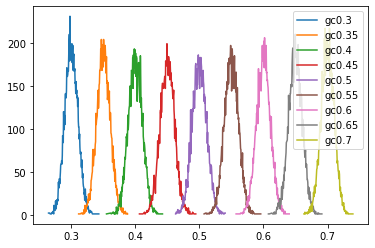

In [44]:
n_gcs = 21
gcs = np.linspace(0, 1, n_gcs)
for i in range(6, 15):
    gc_eff = utils.GC_content(one_hots[i], order='ATGC')
    plt.plot(*np.unique(gc_eff, return_counts=True), label=f'gc{round(gcs[i], 2)}')
plt.legend()
plt.show()
plt.close()

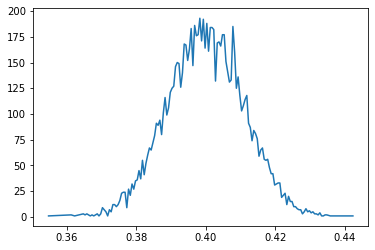

In [39]:
gc_eff = utils.GC_content(one_hots[8], order='ATGC')
plt.plot(*np.unique(gc_eff, return_counts=True))

In [55]:
preds_gc40 = preds.mean(axis=1)[8]
q10, q45, q55, q90 = np.quantile(preds_gc40, [0.1, 0.45, 0.55, 0.9])
low_idx = np.where(preds_gc40 < q10)[0]
lows = one_hots[8, low_idx]
mid_idx = np.where((q45 < preds_gc40) & (preds_gc40 < q55))[0]
mids = one_hots[8, mid_idx]
high_idx = np.where(preds_gc40 > q90)[0]
highs = one_hots[8, high_idx]

In [61]:
df1 = pd.concat({
    'lows': kmer_frequencies(lows, k=1, order='ATGC'),
    'mids': kmer_frequencies(mids, k=1, order='ATGC'),
    'highs': kmer_frequencies(highs, k=1, order='ATGC'),
    }, axis=1)
df1

,lows,mids,highs
A,601674,600072,598777
T,602206,600225,598918
G,398583,400732,401661
C,398537,399971,401644


In [59]:
df = pd.concat({
    'lows': kmer_frequencies(lows, k=2, order='ATGC'),
    'mids': kmer_frequencies(mids, k=2, order='ATGC'),
    'highs': kmer_frequencies(highs, k=2, order='ATGC'),
    }, axis=1)
df

lows    mids   highs
A A  181222  179999  179193
  T  181789  179947  178774
  G  119021  119595  120576
  C  119343  120221  119936
T A  181581  180267  178505
  T  180455  179466  179229
  G  120143  120627  120540
  C  119731  119586  120336
G A  119140  119812  120358
  T  119979  120443  119858
  G   79342   80279   80341
  C   79910   79995   80887
C A  119430  119692  120412
  T  119696  120074  120752
  G   79862   80029   80003
  C   79356   79968   80300

In [60]:
df / df.sum(axis=0)

lows      mids     highs
A A  0.090611  0.089999  0.089596
  T  0.090895  0.089973  0.089387
  G  0.059511  0.059798  0.060288
  C  0.059672  0.060110  0.059968
T A  0.090790  0.090134  0.089252
  T  0.090228  0.089733  0.089614
  G  0.060071  0.060313  0.060270
  C  0.059866  0.059793  0.060168
G A  0.059570  0.059906  0.060179
  T  0.059990  0.060221  0.059929
  G  0.039671  0.040140  0.040170
  C  0.039955  0.039997  0.040444
C A  0.059715  0.059846  0.060206
  T  0.059848  0.060037  0.060376
  G  0.039931  0.040015  0.040002
  C  0.039678  0.039984  0.040150

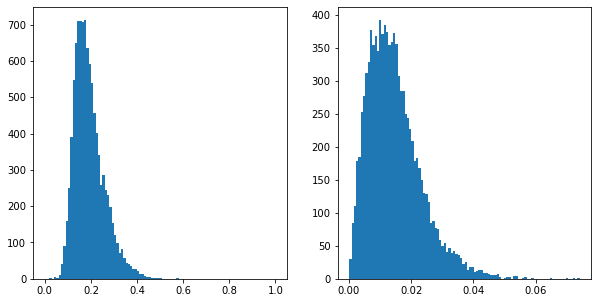

In [45]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(preds.mean(axis=1)[8], bins=100, range=(0, 1))
plt.subplot(122)
plt.hist(preds.std(axis=1)[8], bins=100)
plt.show()
plt.close()

In [17]:
preds_nuc_rand_sim = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'preds_all_reps_myco_nucleosome_random_2mer_as_refs_indep_1000.npy'))
preds_coh_rand_sim = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'preds_all_reps_myco_cohesine_random_2mer_as_refs_indep_32.npy'))
preds_pol_rand_sim = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'preds_all_reps_myco_pol_random_2mer_as_refs_indep_32.npy'))
preds_nuc_rand_sim.shape, preds_coh_rand_sim.shape, preds_pol_rand_sim.shape

((3, 3000), (3, 24576), (3, 1536))

In [24]:
preds_nuc_rand = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'preds_all_reps_myco_nucleosome_randomGC_indep_10000.npy'))
preds_coh_rand = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'preds_all_reps_myco_cohesine_randomGC_indep_32.npy'))
preds_pol_rand = np.load(Path(data_dir, species, 'results', 'models_etienne', 'random_seqs', f'preds_all_reps_myco_pol_randomGC_indep_32.npy'))
preds_nuc_rand.shape, preds_coh_rand.shape, preds_pol_rand.shape

((21, 30000), (21, 24576), (21, 1536))

### Load and normalize labels

In [18]:
def log(x):
    x_ = np.copy(x)
    x_[np.isnan(x_)] = 0
    x_[np.isinf(x_)] = np.percentile(x_, 98)
    # x_[np.isinf(x_)] = np.percentile(x_, 99.5)
    # x_[np.isinf(x_)] = np.percentile(x_, 90)
    x_ = np.log2(x_ + 1)
    return x_

Load nucleosome labels

In [19]:
with_log = False
with_conv = False
if with_log:
    process = lambda x: np.log2(1 + x)
else:
    process = lambda x: x
if with_conv:
    conv = lambda x: np.convolve(x, np.ones(21), mode='same') / 21
else:
    conv = lambda x: x

labels_nuc_m = {}
bw = pyBigWig.open('../shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/myco/coverage_RPKM_myco265.bw')
for chr_id in bw.chroms():
    if chr_id[:3] == 'chr':
        labels_nuc_m[chr_id] = process(bw.values(chr_id, 0, -1, numpy=True))
labels_nuc_m['myco'] = process(bw.values('Mmm_Linear_740kb.fa', 0, -1, numpy=True))
bw.close()
thres_nuc_m = sum([v.sum() for v in labels_nuc_m.values()]) / 1e6
thres_nuc_m_log = sum([np.log2(1 + v).sum() for v in labels_nuc_m.values()]) / 1e6
print(thres_nuc_m, thres_nuc_m_log)

bw = pyBigWig.open('../shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM_pneumo205.bw')
labels_nuc_p = {}
for chr_id in bw.chroms():
    if chr_id[:3] == 'chr':
        labels_nuc_p[chr_id] = process(bw.values(chr_id, 0, -1, numpy=True))
labels_nuc_p['pneu'] = process(bw.values('Pneu300', 0, -1, numpy=True))
bw.close()
thres_nuc_p = sum([v.sum() for v in labels_nuc_p.values()]) / 1e6
thres_nuc_p_log = sum([np.log2(1 + v).sum() for v in labels_nuc_p.values()]) / 1e6
print(thres_nuc_p, thres_nuc_p_log)

labels_nuc = {}
for chr_id, lab in labels_nuc_m.items():
    labels_nuc[chr_id] = conv(lab) / thres_nuc_m
labels_nuc['pneu'] = conv(labels_nuc_p['pneu']) / thres_nuc_p

labels_nuc_yeast = np.concatenate([v for k, v in labels_nuc.items() if k[:3]=='chr'])
print('yeast', labels_nuc_yeast.mean(), labels_nuc_yeast.std())
print('myco', labels_nuc['myco'].mean(), labels_nuc['myco'].std())
print('pneumo', labels_nuc['pneu'].mean(), labels_nuc['pneu'].std())

# q99 = np.quantile(np.concatenate([v for v in norm_labels.values()]), 0.99)
# print(q99)
# clip_labels = {k: np.clip(v, None, q99) / q99 for k, v in norm_labels.items()}
# clip_yeast = np.concatenate([v for k, v in clip_labels.items() if k[:3]=='chr'])
# clip_myco = clip_labels['myco']
# clip_pneu = clip_labels['pneu']
# print('yeast', clip_yeast.mean(), clip_yeast.std())
# print('myco', clip_myco.mean(), clip_myco.std())
# print('pneumo', clip_pneu.mean(), clip_pneu.std())

591.026041 41.995779375
710.084567 49.40572525
yeast 0.07983067 0.21724695
myco 0.014953886 0.04790398
pneumo 0.1070712 0.10929835


Load cohesine labels

In [20]:
labels_coh_m1 = {}
bw = pyBigWig.open('../shared_folder/SCerevisiae/data/Data_etienne/GSM6703630_Scc1_Mmyco_rep1.CPM.bw')
for chr_id in bw.chroms():
    if chr_id[:3] == 'chr':
        key = 'chr' + format(utils.roman_to_int(chr_id[3:]), '02d')
        labels_coh_m1[key] = np.nan_to_num(bw.values(chr_id, 0, -1, numpy=True))
labels_coh_m1['myco'] = np.nan_to_num(bw.values('Mmmyco', 0, -1, numpy=True))
bw.close()
thres_m1 = sum([v.sum() for v in labels_coh_m1.values()]) / 1e6
print(thres_m1)
for chr_id, val in labels_coh_m1.items():
    labels_coh_m1[chr_id] = val / thres_m1

labels_coh_m2 = {}
bw = pyBigWig.open('../shared_folder/SCerevisiae/data/Data_etienne/GSM6703631_Scc1-inp_Mmyco_rep1.CPM.bw')
for chr_id in bw.chroms():
    if chr_id[:3] == 'chr':
        key = 'chr' + format(utils.roman_to_int(chr_id[3:]), '02d')
        labels_coh_m2[key] = np.nan_to_num(bw.values(chr_id, 0, -1, numpy=True))
labels_coh_m2['myco'] = np.nan_to_num(bw.values('Mmmyco', 0, -1, numpy=True))
bw.close()
thres_m2 = sum([v.sum() for v in labels_coh_m2.values()]) / 1e6
print(thres_m2)
for chr_id, val in labels_coh_m2.items():
    labels_coh_m2[chr_id] = val / thres_m2

labels_coh_m = {}
for chr_id, val in labels_coh_m1.items():
    labels_coh_m[chr_id] = log(val / labels_coh_m2[chr_id])
thres_coh_m = sum([v.sum() for v in labels_coh_m.values()]) / 1e6
print(thres_coh_m)

313.6779665
277.9922755
10.762668109375


/tmp/ipykernel_762858/1692398388.py:29: RuntimeWarning: divide by zero encountered in true_divide
  labels_coh_m[chr_id] = log(val / labels_coh_m2[chr_id])
/tmp/ipykernel_762858/1692398388.py:29: RuntimeWarning: invalid value encountered in true_divide
  labels_coh_m[chr_id] = log(val / labels_coh_m2[chr_id])


In [21]:
labels_coh_p1 = {}
bw = pyBigWig.open('../shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM219.bw')
for chr_id in bw.chroms():
    if chr_id[:3] == 'chr':
        labels_coh_p1[chr_id] = bw.values(chr_id, 0, -1, numpy=True)
labels_coh_p1['pneu'] = bw.values('Pneu300', 0, -1, numpy=True)
bw.close()
thres_p1 = sum([v.sum() for v in labels_coh_p1.values()]) / 1e6
print(thres_p1)
for chr_id, val in labels_coh_p1.items():
    labels_coh_p1[chr_id] = val / thres_p1

labels_coh_p2 = {}
bw = pyBigWig.open('../shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM220.bw')
for chr_id in bw.chroms():
    if chr_id[:3] == 'chr':
        labels_coh_p2[chr_id] = bw.values(chr_id, 0, -1, numpy=True)
labels_coh_p2['pneu'] = bw.values('Pneu300', 0, -1, numpy=True)
bw.close()
thres_p2 = sum([v.sum() for v in labels_coh_p2.values()]) / 1e6
print(thres_p2)
for chr_id, val in labels_coh_p2.items():
    labels_coh_p2[chr_id] = val / thres_p2

labels_coh_p = {}
for chr_id, val in labels_coh_p1.items():
    labels_coh_p[chr_id] = log(val / labels_coh_p2[chr_id])
thres_coh_p = sum([v.sum() for v in labels_coh_p.values()]) / 1e6
print(thres_coh_p)

labels_coh = {}
for chr_id, lab in labels_coh_p.items():
    labels_coh[chr_id] = lab / thres_coh_p
labels_coh['myco'] = np.zeros(len(labels_nuc['myco']))
labels_coh['myco'] = labels_coh_m['myco'] / thres_coh_m
# labels_coh = {}
# for chr_id, lab in labels_coh_m.items():
#     labels_coh[chr_id] = lab / thres_coh_m
# labels_coh['pneu'] = labels_coh_p['pneu'] / thres_coh_p

labels_coh_yeast = np.concatenate([v for k, v in labels_coh.items() if k[:3]=='chr'])
print('yeast', labels_coh_yeast.mean(), labels_coh_yeast.std())
print('myco', labels_coh['myco'].mean(), labels_coh['myco'].std())
print('pneumo', labels_coh['pneu'].mean(), labels_coh['pneu'].std())

34891.585536
32648.666752
10.693512875
yeast 0.076353185 0.062700585
myco 0.12220762 0.06999349
pneumo 0.074627675 0.050745565


/tmp/ipykernel_762858/2258831341.py:27: RuntimeWarning: divide by zero encountered in true_divide
  labels_coh_p[chr_id] = log(val / labels_coh_p2[chr_id])
/tmp/ipykernel_762858/2258831341.py:27: RuntimeWarning: invalid value encountered in true_divide
  labels_coh_p[chr_id] = log(val / labels_coh_p2[chr_id])


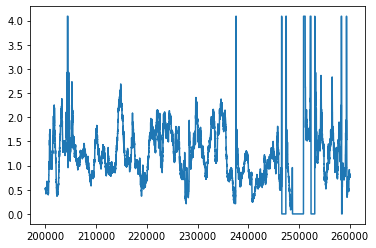

In [15]:
chr_id = 'myco'
start = 200_000
stop = start + 60_000
plt.plot(np.arange(start, stop), labels_coh_m[chr_id][start:stop], label='cohesine_m')
# plt.plot(np.arange(start, stop), labels_coh_p[chr_id][start:stop], label='cohesine_p', alpha=0.7)
plt.show()
plt.close()

Load pol labels

In [22]:
labels_pol_m1 = {}
bw = pyBigWig.open('../shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/myco/coverage_RPKM102.bw')
for chr_id in bw.chroms():
    if chr_id[:3] == 'chr':
        labels_pol_m1[chr_id] = bw.values(chr_id, 0, -1, numpy=True)
labels_pol_m1['myco'] = bw.values('Mmm_Linear_740kb.fa', 0, -1, numpy=True)
bw.close()
thres_m1 = sum([v.sum() for v in labels_pol_m1.values()]) / 1e6
print(thres_m1)
for chr_id, val in labels_pol_m1.items():
    labels_pol_m1[chr_id] = val / thres_m1

labels_pol_m2 = {}
bw = pyBigWig.open('../shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/myco/coverage_RPKM105.bw')
for chr_id in bw.chroms():
    if chr_id[:3] == 'chr':
        labels_pol_m2[chr_id] = bw.values(chr_id, 0, -1, numpy=True)
labels_pol_m2['myco'] = bw.values('Mmm_Linear_740kb.fa', 0, -1, numpy=True)
bw.close()
thres_m2 = sum([v.sum() for v in labels_pol_m2.values()]) / 1e6
print(thres_m2)
for chr_id, val in labels_pol_m2.items():
    labels_pol_m2[chr_id] = val / thres_m2

labels_pol_m = {}
for chr_id, val in labels_pol_m1.items():
    labels_pol_m[chr_id] = log(val / labels_pol_m2[chr_id])
thres_pol_m = sum([v.sum() for v in labels_pol_m.values()]) / 1e6
print(thres_pol_m)

labels_pol_p1 = {}
bw = pyBigWig.open('../shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM154.bw')
for chr_id in bw.chroms():
    if chr_id[:3] == 'chr':
        labels_pol_p1[chr_id] = bw.values(chr_id, 0, -1, numpy=True)
labels_pol_p1['pneu'] = bw.values('Pneu300', 0, -1, numpy=True)
bw.close()
thres_p1 = sum([v.sum() for v in labels_pol_p1.values()]) / 1e6
print(thres_p1)
for chr_id, val in labels_pol_p1.items():
    labels_pol_p1[chr_id] = val / thres_p1

labels_pol_p2 = {}
bw = pyBigWig.open('../shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM155.bw')
for chr_id in bw.chroms():
    if chr_id[:3] == 'chr':
        labels_pol_p2[chr_id] = bw.values(chr_id, 0, -1, numpy=True)
labels_pol_p2['pneu'] = bw.values('Pneu300', 0, -1, numpy=True)
bw.close()
thres_p2 = sum([v.sum() for v in labels_pol_p2.values()]) / 1e6
print(thres_p2)
for chr_id, val in labels_pol_p2.items():
    labels_pol_p2[chr_id] = val / thres_p2

labels_pol_p = {}
for chr_id, val in labels_pol_p1.items():
    labels_pol_p[chr_id] = log(val / labels_pol_p2[chr_id])
thres_pol_p = sum([v.sum() for v in labels_pol_p.values()]) / 1e6
print(thres_pol_p)

labels_pol = {}
for chr_id, lab in labels_pol_m.items():
    labels_pol[chr_id] = lab / thres_pol_m
labels_pol['pneu'] = labels_pol_p['pneu'] / thres_pol_p

labels_pol_yeast = np.concatenate([v for k, v in labels_pol.items() if k[:3]=='chr'])
print('yeast', labels_pol_yeast.mean(), labels_pol_yeast.std())
print('myco', labels_pol['myco'].mean(), labels_pol['myco'].std())
print('pneumo', labels_pol['pneu'].mean(), labels_pol['pneu'].std())

34889.006016
33622.081024
10.449552265625


/tmp/ipykernel_762858/381876048.py:27: RuntimeWarning: divide by zero encountered in true_divide
  labels_pol_m[chr_id] = log(val / labels_pol_m2[chr_id])
/tmp/ipykernel_762858/381876048.py:27: RuntimeWarning: invalid value encountered in true_divide
  labels_pol_m[chr_id] = log(val / labels_pol_m2[chr_id])


34871.929664
32797.221888
9.571089109375
yeast 0.07629484 0.06461104
myco 0.050530758 0.040691163
pneumo 0.088213086 0.079118885


/tmp/ipykernel_762858/381876048.py:57: RuntimeWarning: divide by zero encountered in true_divide
  labels_pol_p[chr_id] = log(val / labels_pol_p2[chr_id])
/tmp/ipykernel_762858/381876048.py:57: RuntimeWarning: invalid value encountered in true_divide
  labels_pol_p[chr_id] = log(val / labels_pol_p2[chr_id])


Compute GC content

In [23]:
species = 'SCerevisiae'
with np.load(Path(data_dir, species, 'genome', 'W303', 'W303.npz')) as f:
    gc_yeast = utils.GC_content(np.concatenate(([v for k, v in f.items() if k[:3]=='chr'])).reshape(1, -1, 4))
with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Mmm_Linear_740kb.npz')) as f:
    gc_myco = utils.GC_content(f['chr1'].reshape(1, -1, 4))
with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Pneu300.npz')) as f:
    gc_pneu = utils.GC_content(f['chr1'].reshape(1, -1, 4))
print(gc_yeast, gc_myco, gc_pneu)

[0.3833779] [0.2415605] [0.40010954]


Load predictions of first model

In [25]:
preds_nuc = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_nuc[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_on_Mmm_Linear_740kb.npz')) as f:
    preds_nuc['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_on_Pneu300.npz')) as f:
    preds_nuc['pneu'] = f['chr1']
thres_pred_nm = sum([np.sum(v) for k, v in preds_nuc.items() if k!='pneu']) / 1e6
print(thres_pred_nm)

preds_nuc2 = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep2_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_nuc2[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep2_on_Mmm_Linear_740kb.npz')) as f:
    preds_nuc2['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep2_on_Pneu300.npz')) as f:
    preds_nuc2['pneu'] = f['chr1']
thres_pred2_nm = sum([np.sum(v) for k, v in preds_nuc2.items() if k!='pneu']) / 1e6
print(thres_pred2_nm)

preds_nuc3 = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep3_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_nuc3[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep3_on_Mmm_Linear_740kb.npz')) as f:
    preds_nuc3['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep3_on_Pneu300.npz')) as f:
    preds_nuc3['pneu'] = f['chr1']
thres_pred3_nm = sum([np.sum(v) for k, v in preds_nuc3.items() if k!='pneu']) / 1e6
print(thres_pred3_nm)

2.4999501792400705
2.4288635174474864
2.511639808070898


In [26]:
preds_coh = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_coh[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_on_Mmm_Linear_740kb.npz')) as f:
    preds_coh['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_on_Pneu300.npz')) as f:
    preds_coh['pneu'] = f['chr1']
thres_pred_cm = sum([np.sum(v) for k, v in preds_coh.items() if k!='pneu']) / 1e6
print(thres_pred_cm)

14.900761329948425


In [27]:
preds_pol = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_on_W303.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds_pol[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_on_Mmm_Linear_740kb.npz')) as f:
    preds_pol['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_on_Pneu300.npz')) as f:
    preds_pol['pneu'] = f['chr1']
thres_pred_pm = sum([np.sum(v) for k, v in preds_pol.items() if k!='pneu']) / 1e6
print(thres_pred_pm)

7.687648562885284


Plot predictions vs GC content on random and true sequences

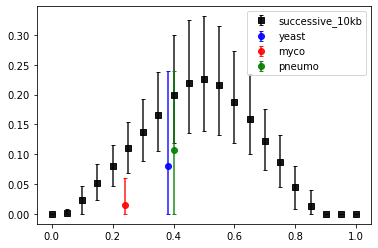

In [17]:
n_gcs = len(preds_nuc_rand)
gcs = np.linspace(0, 1, n_gcs)
q_min, q_max = 0.1, 0.9
# plt.errorbar(gcs, y=preds.mean(axis=1), yerr=np.quantile(preds, [q_min, q_max], axis=1), fmt='ys', alpha=0.9, label='successive', capsize=2)
mean_nuc = preds_nuc_rand.mean(axis=1)
plt.errorbar(gcs, y=mean_nuc, yerr=np.abs(mean_nuc - np.quantile(preds_nuc_rand, [q_min, q_max], axis=1)), fmt='ks', alpha=0.9, label='successive_10kb', capsize=2)
# plt.errorbar(gcs, y=preds_indep.mean(axis=1), yerr=np.quantile(preds_indep, [q_min, q_max], axis=1), fmt='ys', alpha=0.9, label='independent')
mean_yeast = norm_yeast.mean()
mean_myco = norm_myco.mean()
mean_pneu = norm_pneu.mean()
plt.errorbar(gc_yeast, y=[mean_yeast], yerr=np.abs(mean_yeast - np.quantile(norm_yeast, [q_min, q_max])).reshape(2, 1), fmt='bo', alpha=0.9, label='yeast', capsize=2)
plt.errorbar(gc_myco, y=[mean_myco], yerr=np.abs(mean_myco - np.quantile(norm_myco, [q_min, q_max])).reshape(2, 1), fmt='ro', alpha=0.9, label='myco', capsize=2)
plt.errorbar(gc_pneu, y=[mean_pneu], yerr=np.abs(mean_pneu - np.quantile(norm_pneu, [q_min, q_max])).reshape(2, 1), fmt='go', alpha=0.9, label='pneumo', capsize=2)
plt.legend()

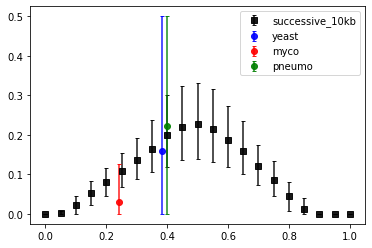

In [19]:
n_gcs = len(preds_nuc_rand)
gcs = np.linspace(0, 1, n_gcs)
q_min, q_max = 0.1, 0.9
mean_nuc = preds_nuc_rand.mean(axis=1)
plt.errorbar(gcs, y=mean_nuc, yerr=np.abs(mean_nuc - np.quantile(preds_nuc_rand, [q_min, q_max], axis=1)), fmt='ks', alpha=0.9, label='successive_10kb', capsize=2)
mean_yeast = clip_yeast.mean()
mean_myco = clip_myco.mean()
mean_pneu = clip_pneu.mean()
plt.errorbar(gc_yeast, y=[mean_yeast], yerr=np.abs(mean_yeast - np.quantile(clip_yeast, [q_min, q_max])).reshape(2, 1), fmt='bo', alpha=0.9, label='yeast', capsize=2)
plt.errorbar(gc_myco, y=[mean_myco], yerr=np.abs(mean_myco - np.quantile(clip_myco, [q_min, q_max])).reshape(2, 1), fmt='ro', alpha=0.9, label='myco', capsize=2)
plt.errorbar(gc_pneu, y=[mean_pneu], yerr=np.abs(mean_pneu - np.quantile(clip_pneu, [q_min, q_max])).reshape(2, 1), fmt='go', alpha=0.9, label='pneumo', capsize=2)
plt.legend()

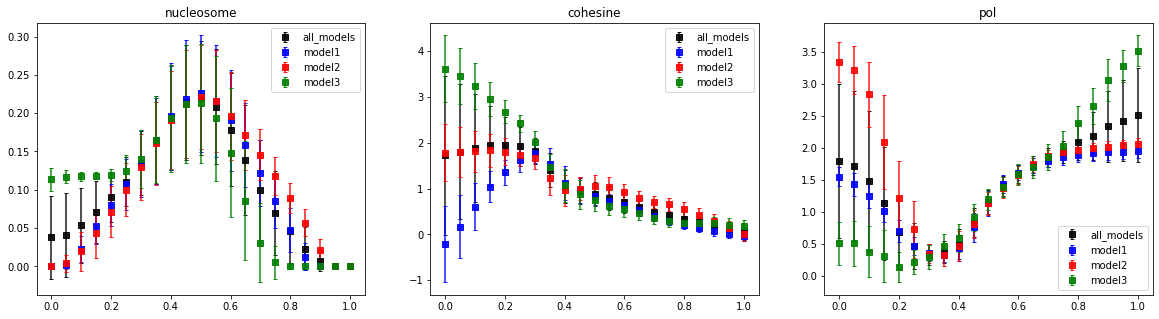

In [28]:
n_gcs = len(preds_nuc_rand)
gcs = np.linspace(0, 1, n_gcs)
q_min, q_max = 0.1, 0.9
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.title('nucleosome')
mean_nuc_rand = preds_nuc_rand.mean(axis=1)
plt.errorbar(gcs, y=mean_nuc_rand, yerr=preds_nuc_rand.std(axis=1), fmt='ks', alpha=0.9, label='all_models', capsize=2)
means_nuc_rand = preds_nuc_rand.reshape(n_gcs, 3, -1).mean(axis=2)
stds_nuc_rand = preds_nuc_rand.reshape(n_gcs, 3, -1).std(axis=2)
fmts = ['bs', 'rs', 'gs']
for i in range(3):
    plt.errorbar(gcs, y=means_nuc_rand[:, i], yerr=stds_nuc_rand[:, i], fmt=fmts[i], alpha=0.9, label=f'model{i+1}', capsize=2)
plt.legend()

plt.subplot(132)
plt.title('cohesine')
mean_coh_rand = preds_coh_rand.mean(axis=1)
plt.errorbar(gcs, y=mean_coh_rand, yerr=preds_coh_rand.std(axis=1), fmt='ks', alpha=0.9, label='all_models', capsize=2)
# plt.errorbar(gcs, y=preds_coh_rand.reshape(n_gcs, 3, -1)[:, :2, :].mean(axis=(1, 2)), yerr=preds_coh_rand.reshape(n_gcs, 3, -1)[:, :2, :].std(axis=(1, 2)), fmt='ks', alpha=0.9, label='all_models', capsize=2)
means_coh_rand = preds_coh_rand.reshape(n_gcs, 3, -1).mean(axis=2)
stds_coh_rand = preds_coh_rand.reshape(n_gcs, 3, -1).std(axis=2)
fmts = ['bs', 'rs', 'gs']
for i in range(3):
    plt.errorbar(gcs, y=means_coh_rand[:, i], yerr=stds_coh_rand[:, i], fmt=fmts[i], alpha=0.9, label=f'model{i+1}', capsize=2)
plt.legend()

plt.subplot(133)
plt.title('pol')
mean_pol_rand = preds_pol_rand.mean(axis=1)
plt.errorbar(gcs, y=mean_pol_rand, yerr=preds_pol_rand.std(axis=1), fmt='ks', alpha=0.9, label='all_models', capsize=2)
means_pol_rand = preds_pol_rand.reshape(n_gcs, 3, -1).mean(axis=2)
stds_pol_rand = preds_pol_rand.reshape(n_gcs, 3, -1).std(axis=2)
fmts = ['bs', 'rs', 'gs']
for i in range(3):
    plt.errorbar(gcs, y=means_pol_rand[:, i], yerr=stds_pol_rand[:, i], fmt=fmts[i], alpha=0.9, label=f'model{i+1}', capsize=2)
plt.legend()

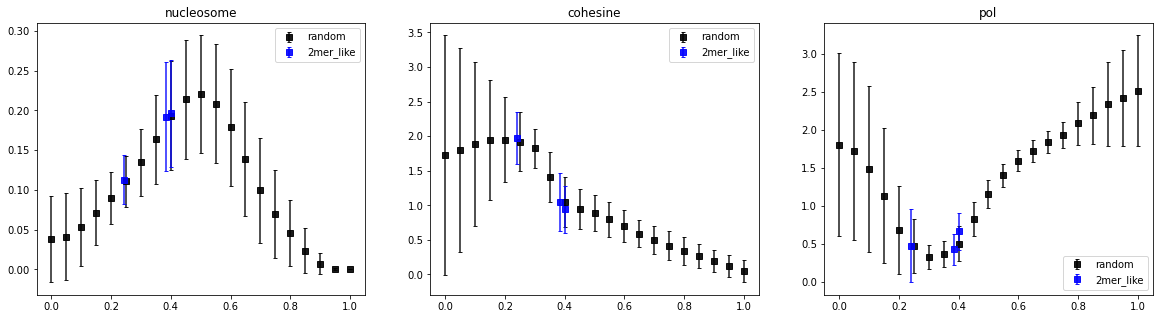

In [34]:
n_gcs = len(preds_nuc_rand)
gcs = np.linspace(0, 1, n_gcs)
gc_refs = np.concatenate([gc_yeast, gc_myco, gc_pneu])
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.title('nucleosome')
plt.errorbar(gcs, y=preds_nuc_rand.mean(axis=1), yerr=preds_nuc_rand.std(axis=1), fmt='ks', alpha=0.9, label='random', capsize=2)
plt.errorbar(gc_refs, y=preds_nuc_rand_sim.mean(axis=1), yerr=preds_nuc_rand_sim.std(axis=1), fmt='bs', alpha=0.9, label='2mer_like', capsize=2)
plt.legend()

plt.subplot(132)
plt.title('cohesine')
plt.errorbar(gcs, y=preds_coh_rand.mean(axis=1), yerr=preds_coh_rand.std(axis=1), fmt='ks', alpha=0.9, label='random', capsize=2)
plt.errorbar(gc_refs, y=preds_coh_rand_sim.mean(axis=1), yerr=preds_coh_rand_sim.std(axis=1), fmt='bs', alpha=0.9, label='2mer_like', capsize=2)
plt.legend()

plt.subplot(133)
plt.title('pol')
plt.errorbar(gcs, y=preds_pol_rand.mean(axis=1), yerr=preds_pol_rand.std(axis=1), fmt='ks', alpha=0.9, label='random', capsize=2)
plt.errorbar(gc_refs, y=preds_pol_rand_sim.mean(axis=1), yerr=preds_pol_rand_sim.std(axis=1), fmt='bs', alpha=0.9, label='2mer_like', capsize=2)
plt.legend()

Compute sliding GC content on all windows

In [35]:
def chunk_regions(array, length):
    leftover = len(array) % length
    return array[:-leftover].reshape((-1, length) + array.shape[1:])

In [20]:
window_gc_full = {}
with np.load(Path(data_dir, species, 'genome', 'W303', 'W303.npz')) as f:
    for chr_id in f.keys():
        window_gc_full[chr_id] = utils.sliding_GC(f[chr_id], 2000)

with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Mmm_Linear_740kb.npz')) as f:
    window_gc_full['myco'] = utils.sliding_GC(f['chr1'], 2000)

with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Pneu300.npz')) as f:
    window_gc_full['pneu'] = utils.sliding_GC(f['chr1'], 2000)

In [36]:
window_gc = {}
with np.load(Path(data_dir, species, 'genome', 'W303', 'W303.npz')) as f:
    for chr_id in f.keys():
        window_gc[chr_id] = utils.GC_content(chunk_regions(f[chr_id],  2000))

with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Mmm_Linear_740kb.npz')) as f:
    window_gc['myco'] = utils.GC_content(chunk_regions(f['chr1'],  2000))

with np.load(Path(data_dir, species, 'genome', 'bacterie', 'Pneu300.npz')) as f:
    window_gc['pneu'] = utils.GC_content(chunk_regions(f['chr1'],  2000))

In [37]:
window_labels = {}
for key in labels_nuc.keys():
    window_labels[key] = np.sum(
        chunk_regions(
            np.concatenate(
                [arr.reshape(-1, 1) for arr in (labels_nuc[key], labels_coh[key], labels_pol[key])],
                axis=1),
            2000),
        axis=1) / 2000

In [38]:
window_preds = {}
for key in preds_nuc.keys():
    window_preds[key] = np.sum(
        chunk_regions(
            np.concatenate(
                [arr.reshape(-1, 1) for arr in (preds_nuc[key] / thres_pred_nm, preds_coh[key] / thres_pred_cm, preds_pol[key] / thres_pred_pm)],
                axis=1),
            2000),
        axis=1) / 2000

Concatenate yeast chromosomes

In [40]:
window_gc_yeast = np.concatenate([v for k, v in window_gc.items() if k[:3]=='chr'])
window_labels_yeast = np.concatenate([v for k, v in window_labels.items() if k[:3]=='chr'])
window_preds_yeast = np.concatenate([v for k, v in window_preds.items() if k[:3]=='chr'])

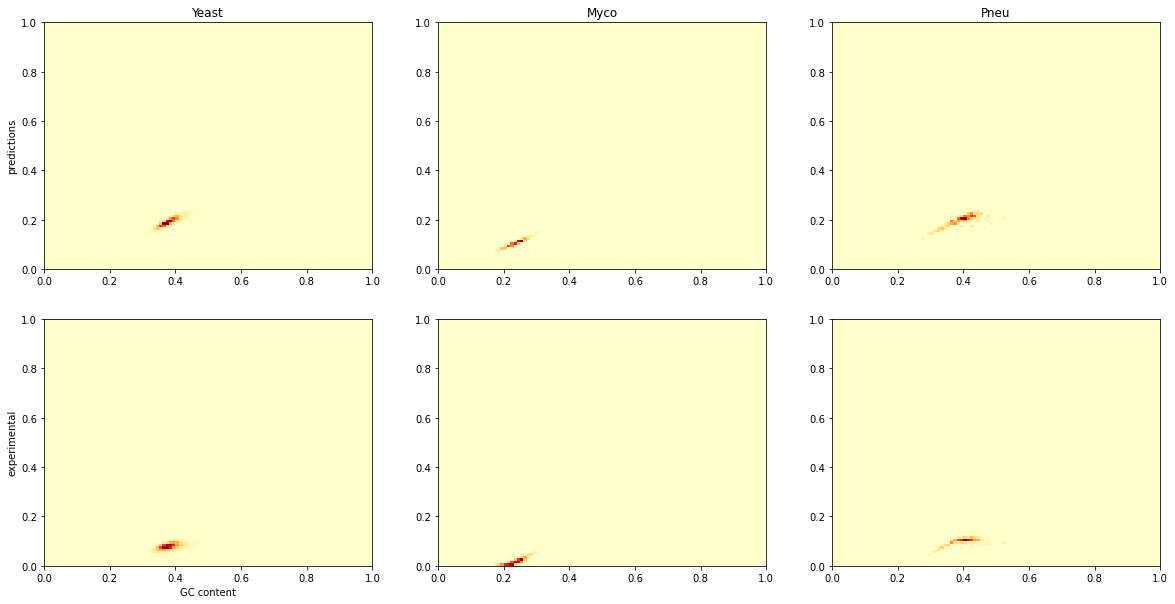

In [133]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(231)
ax.set_title('Yeast')
ax.hist2d(window_gc_yeast, window_preds_yeast[:, 0], bins=100, range=((0, 1), (0, 1)), cmap='YlOrRd')

ax2 = plt.subplot(232)
ax2.set_title('Myco')
ax2.hist2d(window_gc['myco'], window_preds['myco'][:, 0], bins=100, range=((0, 1), (0, 1)), cmap='YlOrRd')

ax3 = plt.subplot(233)
ax3.set_title('Pneu')
ax3.hist2d(window_gc['pneu'], window_preds['pneu'][:, 0], bins=100, range=((0, 1), (0, 1)), cmap='YlOrRd')

ax4 = plt.subplot(234)
ax4.hist2d(window_gc_yeast, window_labels_yeast[:, 0], bins=100, range=((0, 1), (0, 1)), cmap='YlOrRd')

ax5 = plt.subplot(235)
ax5.hist2d(window_gc['myco'], window_labels['myco'][:, 0], bins=100, range=((0, 1), (0, 1)), cmap='YlOrRd')

ax6 = plt.subplot(236)
ax6.hist2d(window_gc['pneu'], window_labels['pneu'][:, 0], bins=100, range=((0, 1), (0, 1)), cmap='YlOrRd')

ax.set_ylabel('predictions')
ax4.set_ylabel('experimental')
ax4.set_xlabel('GC content')
plt.show()
plt.close()

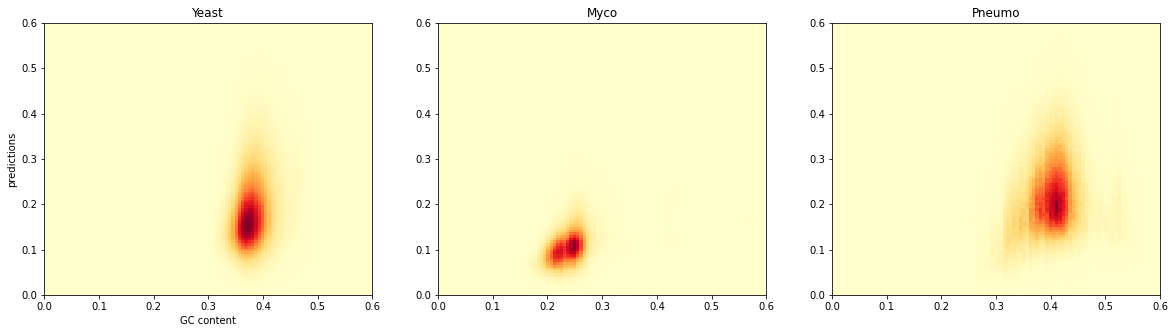

In [137]:
plt.figure(figsize=(20, 5))
ax = plt.subplot(131)
ax.set_title('Yeast')
ax.hist2d(window_gc_yeast, all_preds_yeast, bins=100, range=((0, 0.6), (0, 0.6)), cmap='YlOrRd')

ax2 = plt.subplot(132)
ax2.set_title('Myco')
ax2.hist2d(window_gc['myco'], all_preds['myco'][1000:-1000], bins=100, range=((0, 0.6), (0, 0.6)), cmap='YlOrRd')

ax3 = plt.subplot(133)
ax3.set_title('Pneumo')
ax3.hist2d(window_gc['pneu'], all_preds['pneu'][1000:-1000], bins=100, range=((0, 0.6), (0, 0.6)), cmap='YlOrRd')

ax.set_ylabel('predictions')
ax.set_xlabel('GC content')
plt.show()
plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


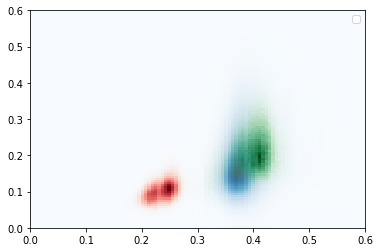

In [140]:
red = plt.cm.Reds
fading_red = red(np.arange(red.N)) # extract colors
fading_red[:, -1] = np.linspace(0, 1, red.N) # modify alpha
fading_red = mpl.colors.ListedColormap(fading_red)
green = plt.cm.Greens
fading_green = green(np.arange(green.N)) # extract colors
fading_green[:, -1] = np.linspace(0, 1, green.N) # modify alpha
fading_green = mpl.colors.ListedColormap(fading_green)
plt.hist2d(window_gc_yeast, all_preds_yeast, bins=100, range=((0, 0.6), (0, 0.6)), cmap='Blues', label='yeast')
plt.hist2d(window_gc['myco'], all_preds['myco'][1000:-1000], bins=100, range=((0, 0.6), (0, 0.6)), cmap=fading_red, label='myco')
plt.hist2d(window_gc['pneu'], all_preds['pneu'][1000:-1000], bins=100, range=((0, 0.6), (0, 0.6)), cmap=fading_green, label='pneumo')
plt.legend()
plt.show()
plt.close()

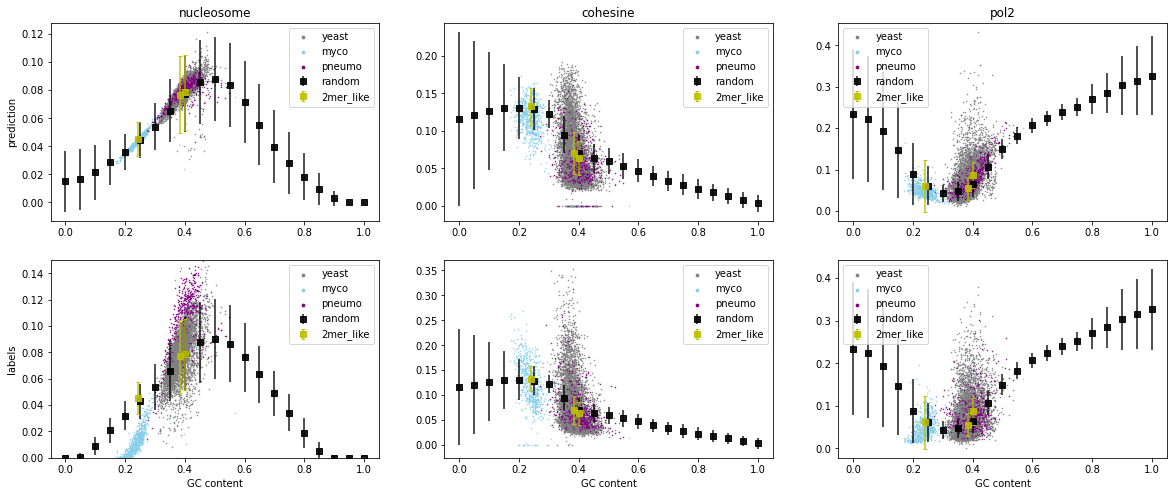

In [41]:
n_gcs = len(preds_nuc_rand)
gcs = np.linspace(0, 1, n_gcs)
gc_refs = np.concatenate([gc_yeast, gc_myco, gc_pneu])
plt.figure(figsize=(20, 8))
titles = ['nucleosome', 'cohesine', 'pol2']
s = 1
s_yeast = 1
for i in range(3):
    plt.subplot(231+i)
    plt.title(titles[i])
    if i == 0:
        plt.errorbar(gcs, y=(preds_nuc_rand / thres_pred_nm).mean(axis=1), yerr=(preds_nuc_rand / thres_pred_nm).std(axis=1), fmt='ks', alpha=0.9, label='random')
        plt.errorbar(gc_refs, y=(preds_nuc_rand_sim / thres_pred_nm).mean(axis=1), yerr=(preds_nuc_rand_sim / thres_pred_nm).std(axis=1), fmt='ys', alpha=0.9, label='2mer_like', capsize=2)
    elif i == 1:
        plt.errorbar(gcs, y=(preds_coh_rand / thres_pred_cm).mean(axis=1), yerr=(preds_coh_rand / thres_pred_cm).std(axis=1), fmt='ks', alpha=0.9, label='random')
        plt.errorbar(gc_refs, y=(preds_coh_rand_sim / thres_pred_cm).mean(axis=1), yerr=(preds_coh_rand_sim / thres_pred_cm).std(axis=1), fmt='ys', alpha=0.9, label='2mer_like', capsize=2)
    else:
        plt.errorbar(gcs, y=(preds_pol_rand / thres_pred_pm).mean(axis=1), yerr=(preds_pol_rand / thres_pred_pm).std(axis=1), fmt='ks', alpha=0.9, label='random')
        plt.errorbar(gc_refs, y=(preds_pol_rand_sim / thres_pred_pm).mean(axis=1), yerr=(preds_pol_rand_sim / thres_pred_pm).std(axis=1), fmt='ys', alpha=0.9, label='2mer_like', capsize=2)
    plt.scatter(window_gc_yeast, window_preds_yeast[:, i], marker='.', color='gray', label='yeast', s=s_yeast)
    plt.scatter(window_gc['myco'], window_preds['myco'][:, i], marker='.', color='skyblue', label='myco', s=s)
    plt.scatter(window_gc['pneu'], window_preds['pneu'][:, i], marker='.', color='purple', label='pneumo', s=s)
    if i == 0:
        plt.ylabel('prediction')
    leg = plt.legend()
    for legh in leg.legendHandles[:3]:
        legh.set_sizes([30])
for i in range(3):
    plt.subplot(234+i)
    if i == 0:
        plt.errorbar(gcs, y=(preds_nuc_rand / thres_pred_nm).reshape(n_gcs, 3, -1).mean(axis=2)[:, 0], yerr=(preds_nuc_rand / thres_pred_nm).reshape(n_gcs, 3, -1).std(axis=2)[:, 0], fmt='ks', alpha=0.9, label='random')
        plt.errorbar(gc_refs, y=(preds_nuc_rand_sim / thres_pred_nm).mean(axis=1), yerr=(preds_nuc_rand_sim / thres_pred_nm).std(axis=1), fmt='ys', alpha=0.9, label='2mer_like', capsize=2)
    elif i == 1:
        plt.errorbar(gcs, y=(preds_coh_rand / thres_pred_cm).mean(axis=1), yerr=(preds_coh_rand / thres_pred_cm).std(axis=1), fmt='ks', alpha=0.9, label='random')
        plt.errorbar(gc_refs, y=(preds_coh_rand_sim / thres_pred_cm).mean(axis=1), yerr=(preds_coh_rand_sim / thres_pred_cm).std(axis=1), fmt='ys', alpha=0.9, label='2mer_like', capsize=2)
    else:
        plt.errorbar(gcs, y=(preds_pol_rand / thres_pred_pm).mean(axis=1), yerr=(preds_pol_rand / thres_pred_pm).std(axis=1), fmt='ks', alpha=0.9, label='random')
        plt.errorbar(gc_refs, y=(preds_pol_rand_sim / thres_pred_pm).mean(axis=1), yerr=(preds_pol_rand_sim / thres_pred_pm).std(axis=1), fmt='ys', alpha=0.9, label='2mer_like', capsize=2)
    plt.scatter(window_gc_yeast, window_labels_yeast[:, i], marker='.', color='gray', label='yeast', s=s_yeast)
    plt.scatter(window_gc['myco'], window_labels['myco'][:, i], marker='.', color='skyblue', label='myco', s=s)
    plt.scatter(window_gc['pneu'], window_labels['pneu'][:, i], marker='.', color='purple', label='pneumo', s=s)
    if i == 0:
        plt.ylabel('labels')
        plt.ylim((0, 0.15))
    plt.xlabel('GC content')
    leg = plt.legend()
    for legh in leg.legendHandles[:3]:
        legh.set_sizes([30])
plt.show()
plt.close()


Distributions of predictions and labels

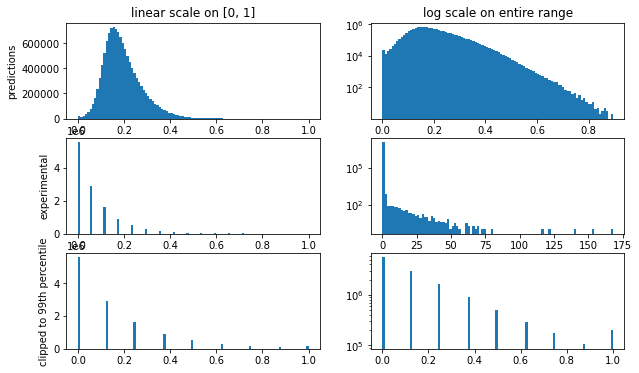

In [123]:
plt.figure(figsize=(10, 6))

plt.subplot(321)
plt.title('linear scale on [0, 1]')
plt.hist(all_preds_yeast, bins=100, range=(0, 1))
plt.ylabel('predictions')

plt.subplot(322)
plt.title('log scale on entire range')
plt.hist(all_preds_yeast, bins=100)
plt.yscale('log')

plt.subplot(323)
plt.hist(norm_yeast, bins=100, range=(0, 1))
plt.ylabel('experimental')

plt.subplot(324)
plt.hist(norm_yeast, bins=100)
plt.yscale('log')

plt.subplot(325)
plt.hist(clip_yeast, bins=100, range=(0, 1))
plt.ylabel('clipped to 99th percentile')

plt.subplot(326)
plt.hist(clip_yeast, bins=100)
plt.yscale('log')

plt.show()
plt.close()

#### Load models

Check model architectures

In [22]:
model = tf.keras.models.load_model(f'{data_dir}/{species}/models_etienne/weights_myco_pol2_2048_16.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
model.summary()
print(model.layers[-1], model.layers[-1].activation)
del model

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 2048, 4)]    0                                            
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 2048, 32)     1568        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_9 (MaxPooling1D)  (None, 256, 32)      0           conv1d_14[0][0]                  
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 256, 32)      128         max_pooling1d_9[0][0]            
_______________________________________________________________________________________

Predict on genomes

In [19]:
species = 'SCerevisiae'
genomes = ['W303', 'Mmm_Linear_740kb', 'Pneu300']
model_files = [
    # (Path(data_dir, species, 'models_etienne', 'weights_myco_rep1.hdf5'), 'nucleosome'),
    # (Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep2.hdf5'), 'nucleosome'),
    # (Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep3.hdf5'), 'nucleosome'),
    # (Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine.hdf5'), 'cohesine'),
    # (Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_2.hdf5'), 'cohesine'),
    # (Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_3.hdf5'), 'cohesine'),
    # (Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16.hdf5'), 'pol'),
    # (Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_2.hdf5'), 'pol'),
    # (Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_3.hdf5'), 'pol'),
    ]
for model_file, annotation_type in model_files:
    for genome in genomes:
        if annotation_type == 'nucleosome':
            model = tf.keras.models.load_model(model_file, custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
            order_suffix = '_ATGC'
        else:
            model = tf.keras.models.load_model(model_file, custom_objects={'correlate' : correlate})
            order_suffix = ''
        if genome == 'W303':
            genome_dir = 'W303'
        else:
            genome_dir = 'bacterie'
        all_preds = {}
        with np.load(Path(data_dir, species, 'genome', genome_dir, f'{genome}{order_suffix}.npz')) as f:
            for chr_id in f.keys():
                one_hot_chr = f[chr_id]
                try:
                    all_preds[chr_id] = predict(one_hot_chr, model, annotation_type)
                except ValueError:
                    print(f"Can't predict on {chr_id}, skipping...")
        del model
        np.savez(Path(data_dir, species, 'results', 'models_etienne', f'preds_{model_file.stem}_on_{genome}.npz'), **all_preds)

Can't predict on p2, skipping...


pearsonr: (0.683715419445692, 0.0)
0.07244701428360163 0.07515196


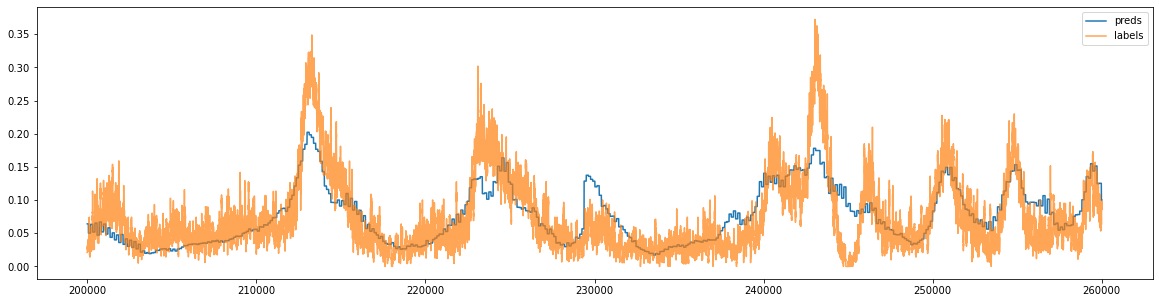

In [57]:
chr_id = 'chr16'
preds = preds_coh[chr_id] / thres_pred_cm
labels = labels_coh[chr_id] # * thres_coh_p
print('pearsonr:', pearsonr(preds, labels))
print(np.mean(preds), np.mean(labels))

start = 200_000
stop = start + 60_000
plt.figure(figsize=(20, 5))
plt.plot(np.arange(start, stop), preds[start:stop], label='preds')#, alpha=0.5, width=1)
plt.plot(np.arange(start, stop), labels[start:stop], label='labels', alpha=0.7)#, width=1)
# plt.plot(np.arange(start, stop), labels_coh_m[chr_id][start:stop], label='labels_m', alpha=0.7)#, width=1)
plt.legend()
plt.savefig('testing_savefig', bbox_inches='tight', facecolor='w')
plt.show()
plt.close()

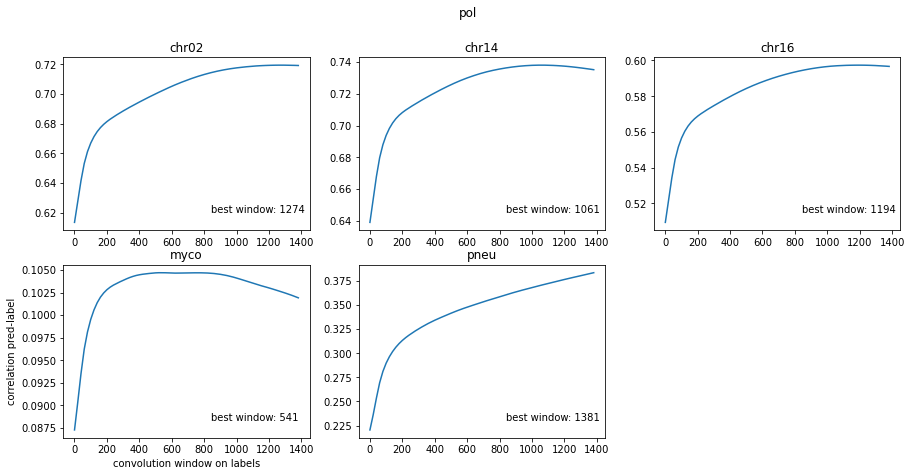

In [168]:
annot = 'pol'
if annot == 'nucleosome':
    preds = preds_nuc
    labels = labels_nuc
    ns = [i for i in range(1, 101)]
elif annot == 'cohesine':
    preds = preds_coh
    labels = labels_coh
    ns = [i for i in range(1, 701, 20)] + [i for i in range(701, 801)] + [i for i in range(801, 1001, 20)]
elif annot == 'pol':
    preds = preds_pol
    labels = labels_pol
    ns = [i for i in range(1, 1101, 20)] + [i for i in range(1101, 1301)] + [i for i in range(1301, 1401, 20)]
plt.figure(figsize=(15, 7))
plt.suptitle(annot)
for i, chr_id in enumerate(['chr02', 'chr14', 'chr16', 'myco', 'pneu']):
    corrs = []
    for n in ns:
        lab = np.convolve(labels[chr_id], np.ones(n), mode='same') / n
        corrs.append(pearsonr(preds[chr_id], lab)[0])
    plt.subplot(231+i)
    plt.plot(ns, corrs)
    plt.title(chr_id)
    if i == 3:
        plt.xlabel('convolution window on labels')
        plt.ylabel('correlation pred-label')
    plt.annotate(f'best window: {ns[np.argmax(corrs)]}', xy=(0.6, 0.1), xycoords="axes fraction")
plt.savefig(Path(data_dir, species, 'results', 'models_etienne', f'corr_{annot}_vs_conv_window.png'), bbox_inches='tight', facecolor='w')
plt.show()
plt.close()

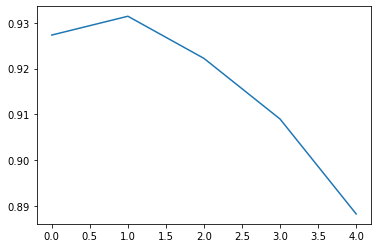

In [8]:
corrs = [pearsonr(pred_nucleosome, pred_nucleosome_rev)[0]]
for offset in range(1, 5):
    corrs.append(pearsonr(pred_nucleosome[offset:], pred_nucleosome_rev[:-offset])[0])
plt.plot(np.arange(len(corrs)), corrs)
plt.show()
plt.close()

In [122]:
with np.load(Path(data_dir, data, 'data', 'chr4_SynEC100.npz')) as f:
    for k in f.keys():
        one_hot_chr_ACGT = f[k]
        break
with np.load(Path(data_dir, data, 'data', 'chr4_SynEC100_ATGC.npz')) as f:
    for k in f.keys():
        one_hot_chr_ATGC = f[k]
        break
with np.load(Path(data_dir, data, 'data', 'chr4_SynEC_UAS_TATA-yeGFP-NLS.npz')) as f:
    for k in f.keys():
        one_hot_chr2_ACGT = f[k]
        break
with np.load(Path(data_dir, data, 'data', 'chr4_SynEC_UAS_TATA-yeGFP-NLS_ATGC.npz')) as f:
    for k in f.keys():
        one_hot_chr2_ATGC = f[k]
        break
one_hot_chr2_ACGT.shape

(125243, 4)

In [169]:
seq = utils.one_hot_decode(one_hot_chr_ACGT)
seq2 = utils.one_hot_decode(one_hot_chr2_ACGT)
ref = utils.one_hot_decode(one_hot_chr_ref_ACGT)

In [225]:
start = 3623
size = 15_045 - start
for i in range(len(ref) - size + 1):
    if seq2[start:start+size] == ref[i:i+size]:
        print(i)

836753


In [262]:
pos = 833_130
start = 65_020
offset = -8625
length = 100
# print(ref[pos+start : pos+start+length])
print(seq[start:start+length])
print(seq2[start+offset:start+offset+length])

CTGTATAAACCAGCGCCACAGAATAGAACCCACTGTACGAGTGATCTGGGTACGGCACTCGGAGCGTAGTAATGGACACCACACATTTCTGGAACCTTTG
CTGTATAAACCAGCGCCACAGAATAGAACCCACTGTACGAGTGATCTGGGTACGGCACTCGGAGCGTAGTAATGGACACCACACATTTCTGGAACCTTTG


In [240]:
i = 68852
while seq[-i-1] == seq2[-i-2]:
    i += 1
print(i)

68852


In [132]:
data = 'SCerevisiae'

model_nucleosome = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_myco_rep1.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
pred_nucleosome = predict(one_hot_chr_ATGC, model_nucleosome, "nucleosome")
pred_nucleosome2 = predict(one_hot_chr2_ATGC, model_nucleosome, "nucleosome")
del model_nucleosome
# model_nucleosome2 = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_nucleosome_myco_rep2.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
# pred_nucleosome2 = predict(one_hot_chr_ATGC, model_nucleosome2, "nucleosome")
# del model_nucleosome2
# model_nucleosome3 = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_nucleosome_myco_rep3.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
# pred_nucleosome3 = predict(one_hot_chr_ATGC, model_nucleosome3, "nucleosome")
# del model_nucleosome3
# model_nucleosome_pneu = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_pneu_rep1.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
# pred_nucleosome_pneu = predict(one_hot_chr_ATGC, model_nucleosome_pneu, "nucleosome")
# del model_nucleosome_pneu
# model_nucleosome_all = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_CNN_nucleosome_in_vivo_all_data.hdf5', custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
# pred_nucleosome_all = predict(one_hot_chr_ATGC, model_nucleosome_all, "nucleosome")
# del model_nucleosome_all

model_cohesine = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_myco_rep1_cohesine.hdf5', custom_objects={'correlate': correlate})
pred_cohesine = predict(one_hot_chr_ACGT, model_cohesine, "cohesine", last_window=True)
pred_cohesine2 = predict(one_hot_chr2_ACGT, model_cohesine, "cohesine", last_window=True)
del model_cohesine

model_pol = tf.keras.models.load_model(f'{data_dir}/{data}/models/weights_myco_pol2_2048_16.hdf5', custom_objects={'correlate' : correlate})
pred_pol = predict(one_hot_chr_ACGT, model_pol, "pol", last_window=True)
pred_pol2 = predict(one_hot_chr2_ACGT, model_pol, "pol", last_window=True)
del model_pol

In [133]:
df = pd.DataFrame({
    'nucleosome': pred_nucleosome,
    'cohesine': pred_cohesine,
    'pol2': pred_pol})
df2 = pd.DataFrame({
    'nucleosome': pred_nucleosome2,
    'cohesine': pred_cohesine2,
    'pol2': pred_pol2})

In [136]:
df.to_csv('../shared_folder/SCerevisiae/results/preds_chr4_SynEC100_full.csv')
df2.to_csv('../shared_folder/SCerevisiae/results/preds_chr4_SynEC_UAS_TATA-yeGFP-NLS_full.csv')

In [264]:
preds = {}
for file in Path('..', 'shared_folder', 'SCerevisiae', 'models').glob('*.hdf5'):
    requires_mae_cor = False
    pred = None
    try:
        model = tf.keras.models.load_model(file, custom_objects={'correlate': correlate})
    except:
        model = tf.keras.models.load_model(file, custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
        requires_mae_cor = True
    try:
        pred = predict(one_hot_chr_ref_ACGT, model, "cohesine")
        annotation_type = "cohesine"
    except:
        try:
            pred = predict(one_hot_chr_ref_ACGT, model, "pol")
            annotation_type = "pol"
        except:
            try:
                pred = predict(one_hot_chr_ref_ATGC, model, "nucleosome")
                annotation_type = "nucleosome"
            except:
                annotation_type = None        
    del model
    preds[file] = pred
    print(file, requires_mae_cor, annotation_type)
    # if pred is not None:
    #     start = 54_000
    #     stop = 59_000
    #     fig, ax = plt.subplots(figsize=(15, 3))
    #     ax.plot(np.arange(start, stop), pred[start:stop], linewidth=0.2)
    #     ax.set_ylim(0, 3)
    #     ax.fill_between(np.arange(start, stop), pred[start:stop], 0)
    

../shared_folder/SCerevisiae/models/weights_myco_rep1_cohesine_3.hdf5 False cohesine
../shared_folder/SCerevisiae/models/weights_myco_pol2_2048_16_2.hdf5 False pol
../shared_folder/SCerevisiae/models/weights_gal_pol2_2048_16.hdf5 False pol
../shared_folder/SCerevisiae/models/weights_CNN_nucleosome_in_vivo_all_data.hdf5 True nucleosome
../shared_folder/SCerevisiae/models/weights_Bassenji_32768_256.hdf5 False cohesine
../shared_folder/SCerevisiae/models/weights_myco_pol2.hdf5 False cohesine
../shared_folder/SCerevisiae/models/weights_pneu_rep1_transcription.hdf5 True nucleosome
../shared_folder/SCerevisiae/models/weights_nucleosome_myco_rep3.hdf5 True nucleosome
../shared_folder/SCerevisiae/models/weights_myco_rep1_cohesine_2.hdf5 False cohesine
../shared_folder/SCerevisiae/models/weights_myco_pol2_2048_16_3.hdf5 False pol
../shared_folder/SCerevisiae/models/weights_pneu_rep1_cohesine_2.hdf5 False cohesine
../shared_folder/SCerevisiae/models/weights_gal_pol2.hdf5 False cohesine
../shared

Predict

In [192]:
smooth_pred_nucleosome = utils.smooth(pred_nucleosome, 201, mode='gaussian', sigma=10)

In [9]:
pred_nucleosome_etienne = np.load(Path(data_dir, data, 'results', 'etienne_nucleosome_pneu_rep1_chr16.npy'))
pred_nucleosome_etienne.shape # 986200
# preds_etienne[-1010:-990]

(986200,)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


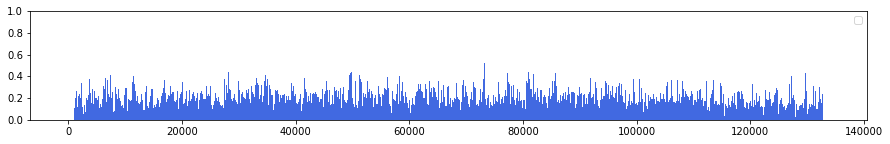

In [48]:
start = 0 #210_000
end = len(df) #220_000
plt.figure(figsize=(15, 4))
# plt.bar(np.arange(start, end), height=pred_nucleosome[start:end], width=1, alpha=1, color=(0, 0, 1), label='pred_myco')
plt.bar(np.arange(start, end), height=df['nucleosome'], width=1, color='royalblue')
# plt.bar(np.arange(start, end), height=pred_nucleosome_etienne[start:end], width=1, alpha=0.3, color=(0, 1, 0), label='pred_etienne')
plt.ylim(0, 1)
plt.legend()
plt.show()
plt.close()

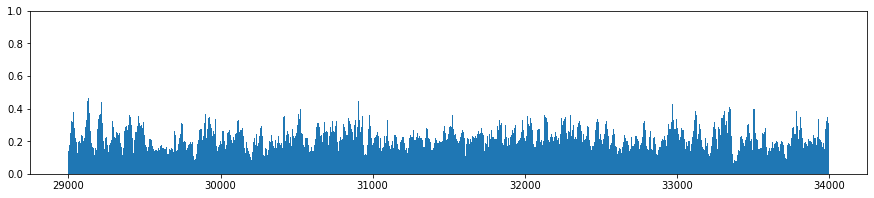

In [181]:
start = 29_000
stop = 34_000
plt.figure(figsize=(15, 3))
plt.bar(np.arange(start, stop), height=df['nucleosome'][start:stop], width=1)
plt.ylim(0, 1)
plt.show()
plt.close()

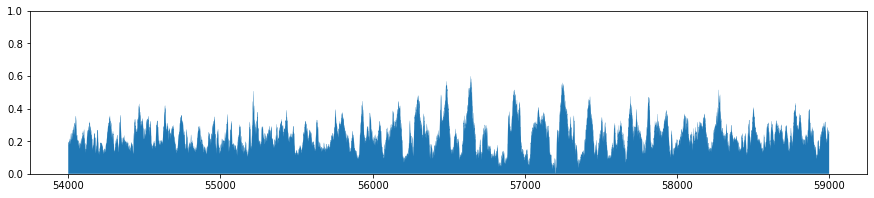

In [185]:
start = 54_000
stop = 59_000
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(np.arange(start, stop), df['nucleosome'][start:stop], linewidth=0.2)
ax.set_ylim(0, 1)
ax.fill_between(np.arange(start, stop), df['nucleosome'][start:stop], 0)
fig.savefig(f'../shared_folder/SCerevisiae/results/pred_chr4_SynEC100_nucleosome_zoom', bbox_inches='tight')

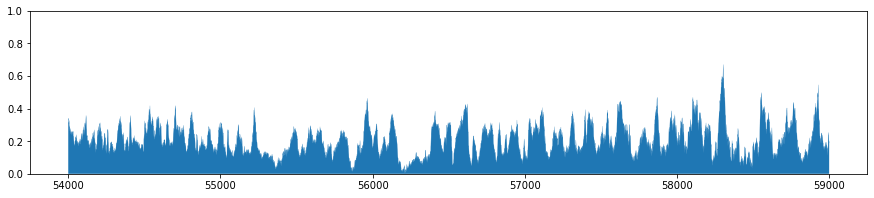

In [186]:
start = 54_000
stop = 59_000
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(np.arange(start, stop), df2['nucleosome'][start:stop], linewidth=0.2)
ax.set_ylim(0, 1)
ax.fill_between(np.arange(start, stop), df2['nucleosome'][start:stop], 0)
fig.savefig(f'../shared_folder/SCerevisiae/results/pred_chr4_SynEC_UAS_TATA-yeGFP-NLS_nucleosome_zoom', bbox_inches='tight')

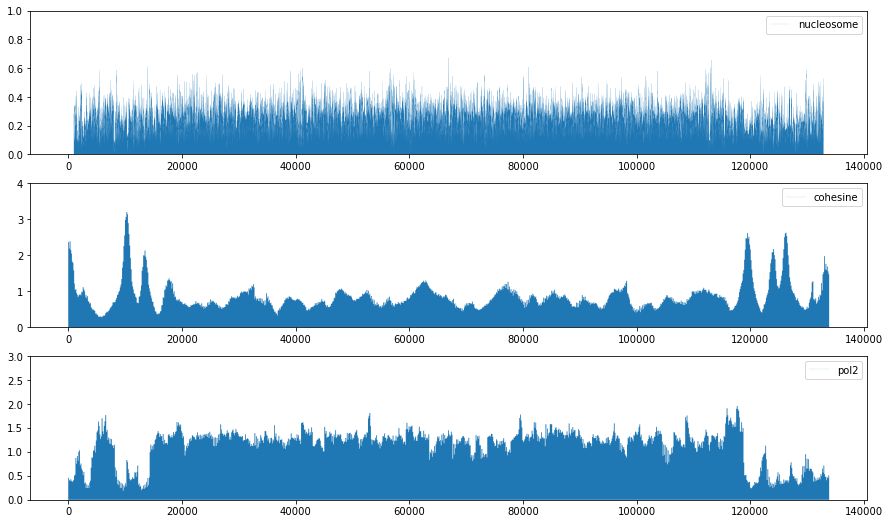

In [135]:
fig, axes = plt.subplots(nrows=3, figsize=(15, 9))
df.plot(y='nucleosome', use_index=True, ylim=(0, 1), ax=axes[0], linewidth=0.1)
axes[0].fill_between(df.index, df['nucleosome'], 0)
df.plot(y='cohesine', use_index=True, ylim=(0, 4), ax=axes[1], linewidth=0.1)
axes[1].fill_between(df.index, df['cohesine'], 0)
df.plot(y='pol2', use_index=True, ylim=(0, 3), ax=axes[2], linewidth=0.1)
axes[2].fill_between(df.index, df['pol2'], 0)
fig.savefig(f'../shared_folder/SCerevisiae/results/preds_chr4_SynEC100_full', bbox_inches='tight')

(0.9999999999998332, 0.0)


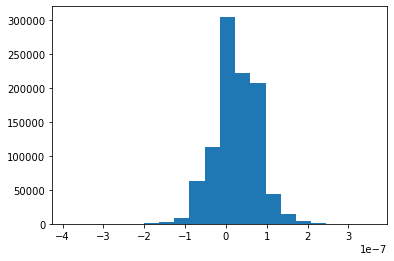

In [20]:
print(pearsonr(pred_nucleosome_pneu, pred_nucleosome_etienne))
diffs = pred_nucleosome_pneu - pred_nucleosome_etienne
plt.hist(diffs, bins=20)
plt.show()
plt.close()

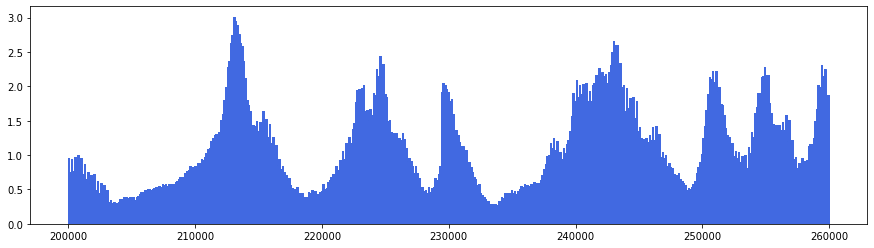

In [35]:
start = 200_000
end = 260_000
plt.figure(figsize=(15, 4))
plt.bar(np.arange(start, end), height=pred_cohesine[start:end], width=1, edgecolor='royalblue')
plt.show()
plt.close()

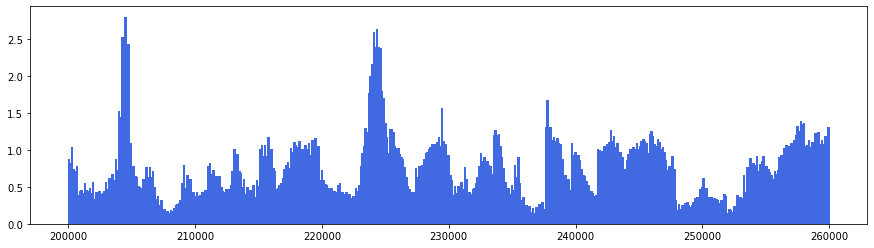

In [32]:
start = 200_000
end = 260_000
plt.figure(figsize=(15, 4))
plt.bar(np.arange(start, end), height=pred_pol[start:end], width=1, edgecolor='royalblue')
plt.show()
plt.close()

## Kinetic Monte Carlo

In [ ]:
# initialisation :
# use ATGC content from SCerevisiae
# build 1000 sequences of length N
# mutation and selection: 
# make every 3*N single nucleotide mutation
# selection probability of 1/norm * exp(-delta_energy / T)
# 10**4 steps
# save each configuration and keep best
# energy :
# create a 2001 + N sequence repeating the length N sequence, centered on it
# distance to target density E_reg is d(x, y) = 1 - corr(x, y) + 1/N * sum(abs(x_i - y_i))
# GC content constraint E_GC is abs(GC_synt - GC_nat) GC_nat=0.38
# E_mut penalizes sequences already seen
# E_rev, like E_reg but on reverse strand
# total energy is exp(-(a*E_GC + b*E_reg + c*E_rev + d*E_mut)/T)

In [5]:
SCer_GC = 0.38
SCer_p = [0.31, 0.19, 0.19, 0.31]

In [12]:
SCer_GC = 0.38
SCer_p = [0.31, 0.19, 0.19, 0.31]
n_seqs = 6
seq_length = 5
seqs1 = np.random.choice(['A', 'C', 'G', 'T'], (n_seqs, seq_length), p=SCer_p)
one_hots1 = utils.one_hot_encoding(seqs1, read_length=seq_length, one_hot_type=int).reshape(n_seqs, seq_length, 4)
seqs2 = np.random.choice(['A', 'C', 'G', 'T'], (n_seqs, seq_length), p=SCer_p)
one_hots2 = utils.one_hot_encoding(seqs2, read_length=seq_length, one_hot_type=int).reshape(n_seqs, seq_length, 4)

In [237]:
from Modules import models
importlib.reload(models)
model = models.build_model('inception_dna_paired_v1')

In [240]:
model.predict([one_hots1, one_hots2])

array([[0.68842316],
       [0.62810767],
       [0.5163134 ],
       [0.56415707]], dtype=float32)

In [28]:
one_hots.shape

(2, 3, 1, 4)

In [29]:
mult = np.ones([1, 1]).reshape(1, 1, 1, 1)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 2)